In [33]:
# Imports and stable code

# Standard library imports
import time
import math
import copy
import os
os.environ["JULIA_NUM_THREADS"] = "1"
from julia.api import Julia
julia = Julia(sysimage="sysimage_env/sysimage.so")
from julia import Main
Main.include("models/myers_model.jl")

import shutil
from tempfile import NamedTemporaryFile
import multiprocessing
from collections import deque
import re
import sqlite3

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize, basinhopping, differential_evolution, dual_annealing, direct, brute, OptimizeResult
from scipy.stats import qmc
from joblib import Parallel, delayed

# Infrastructure functions

# ASA Optimizer
def vfsa_accprob(curr_cost, new_cost, temp_acc):
    exponent = np.clip((new_cost - curr_cost) / temp_acc, -500, 500)
    return 1 / (1 + np.exp(exponent))

def vfsa_gen_step(dim, log_lb, log_ub, temp_gen, rng=None):
    if rng is None: 
        rng = np.random.default_rng()

    uni = rng.random(dim)
    base = 1 + 1 / (temp_gen + 1e-10)  # Small value added to avoid division by zero
    exponent = 2 * uni - 1
    rnd = np.sign(uni - 0.5) * temp_gen * (base**np.abs(exponent) - 1)
    return (log_ub - log_lb) * rnd

def vfsa_gen_params(curr_params, dim, log_lb, log_ub, temp_gen, rng=None):
    if rng is None: 
        rng = np.random.default_rng()

    log_params = np.log10(curr_params)
    flag1 = True

    while flag1:
        # Generate a log step
        log_step = vfsa_gen_step(dim, log_lb, log_ub, temp_gen, rng)
        new_log_params = log_params + log_step

        # Check if all new parameters are within bounds
        if np.all(new_log_params >= log_lb) and np.all(new_log_params <= log_ub):
            # If within bounds, convert back to linear scale and return
            par = 10 ** new_log_params
            flag1 = False
        else:
            # If any parameter is out of bounds, handle each one individually
            for i in range(dim):
                if new_log_params[i] < log_lb[i] or new_log_params[i] > log_ub[i]:
                    flag2 = True
                    while flag2:
                        # Generate a new step for the out-of-bounds parameter
                        log_step = vfsa_gen_step(dim, log_lb, log_ub, temp_gen, rng)
                        new_log_params[i] = log_params[i] + log_step[i]

                        # Check if it's now within bounds
                        if log_lb[i] <= new_log_params[i] <= log_ub[i]:
                            flag2 = False

            # Once all parameters are adjusted, convert to linear scale and exit loop
            par = 10 ** new_log_params
            flag1 = False

    return par
        
def vfsa_generinitpoint(dim, log_lb, log_ub, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    
    # Ensure that bounds are valid (finite numbers)
    if not (np.all(np.isfinite(log_lb)) and np.all(np.isfinite(log_ub))):
        raise ValueError("Bounds must be finite numbers")
    
    # Ensure bounds have proper order: log_lb should be less than or equal to log_ub
    if np.any(log_lb > log_ub):
        raise ValueError("Lower bounds must be less than or equal to upper bounds")
    
    flag = True
    while flag:
        # Generate random uniform numbers for each dimension
        uni = rng.random(dim)
        
        # Calculate log_initpoints within the bounds
        log_initpoints = log_lb + (log_ub - log_lb) * uni
        
        # Check if the new points are within the bounds (they should be)
        if np.all(log_initpoints >= log_lb) and np.all(log_initpoints <= log_ub):
            flag = False
    
    # Return the initial points, exponentiated back from log scale to original scale
    return 10 ** log_initpoints

def vfsa_reannealing(best_cost, best_params, curr_cost, dim, x0, tmax, tscat, data, c, temp_gen, temp0_gen, objective_function):
    log_orig_best_params = np.log10(best_params)
    log_par_delta = log_orig_best_params + 0.01 * log_orig_best_params
    par_delta = 10 ** log_par_delta
    
    cost_delta = np.array([
        objective_function(par_delta if i == j else best_params)
        for j in range(dim)
    ])
    
    par_diff = np.clip(par_delta - best_params, 1e-10, None)  # Avoid division by zero
    s = np.abs((cost_delta - best_cost) / par_diff) * (best_params / best_cost)
    smax = np.max(s)
    
    temp_gen = np.clip(temp_gen * (smax / np.clip(s, 1e-10, None)), 1e-10, None)
    
    k_gen = (-1/c * np.log(np.clip(temp_gen / temp0_gen, 1e-10, None))) ** dim
    k_gen = np.clip(k_gen, 0, None)  # Ensure non-negative values
    
    temp0_acc = curr_cost
    temp_acc = best_cost
    k_acc = (-1/c * np.log(np.clip(temp_acc / temp0_acc, 1e-10, None))) ** dim
    
    return temp_gen, k_gen, temp0_acc, temp_acc, k_acc

def vfsa_temp(temp_gen0, c, k_gen, dim, min_temp=1e-10):
    exponent = -c * np.power(k_gen, 1/dim)
    temp = temp_gen0 * np.exp(exponent)
    return np.clip(temp, min_temp, None)

def simulated_annealing(objective_function, initial_solution, lower_bounds, upper_bounds, 
                        initial_temperature, cooling_rate, max_iterations, neighborhood_function, 
                        log_lb, log_ub, temp_gen, 
                        M=10, eps=0.0, min_temp=1e-10, verbose=False):
    
    current_solution = initial_solution
    current_cost = objective_function(current_solution)
    best_solution = current_solution
    best_cost = current_cost
    temperature = initial_temperature

    reanneal_cost_vec = [best_cost]
    diff = deque(maxlen=M)
    best_diff = deque(maxlen=M)
    count_acc_points = 0

    for iteration in range(max_iterations):
        # Generate a new solution in the neighborhood
        new_solution = neighborhood_function(current_solution, len(current_solution), log_lb, log_ub, temp_gen)
        new_cost = objective_function(new_solution)
        delta_cost = new_cost - current_cost
        
        # Acceptance probability
        if delta_cost < 0 or np.random.rand() < np.exp(-delta_cost / temperature):
            current_solution = new_solution
            current_cost = new_cost
            count_acc_points += 1
            
            # Update the best solution found
            if current_cost < best_cost:
                best_solution = current_solution
                best_cost = current_cost

            # Reannealing: Store the best cost at this point
            reanneal_cost_vec.append(best_cost)
            if len(reanneal_cost_vec) > 1:
                diff.append(abs(reanneal_cost_vec[-1] - reanneal_cost_vec[-2]))
                best_diff.append(abs(reanneal_cost_vec[-1] - best_cost))

                # Termination condition based on the last M accepted costs
                if len(diff) == M and all(d <= eps for d in diff) and all(bd <= eps for bd in best_diff):
                    print('ASA converged, terminating at', iteration)
                    break
        
        # Decrease the temperature with a check for minimum temperature
        temperature = max(min_temp, temperature * cooling_rate)
        
        # Progress print statements
        if iteration % (max_iterations // 10) == 0:
            print(f"Iteration {iteration}")
            if verbose==True:
                print(f"Current cost = {current_cost}, Best cost = {best_cost}")
        
    return best_solution, best_cost

def ASA(objective_function, x0, bounds, maxiter=100, initial_temp=1.0, cooling_rate=0.95, 
        neighborhood_function=vfsa_gen_params, init_function=vfsa_generinitpoint, 
        **kwargs):
    
    dim = len(x0)
    lower_bounds, upper_bounds = np.array(bounds).T
    log_lb, log_ub = np.log10(lower_bounds), np.log10(upper_bounds)
    log_bounds = list(zip(log_lb, log_ub))
    
    # Generate the initial solution
    initial_solution = init_function(dim, log_lb, log_ub)
    
    # Run ASA optimization
    best_solution, best_cost = simulated_annealing(
        objective_function, initial_solution, lower_bounds, upper_bounds,
        initial_temp, cooling_rate, maxiter, neighborhood_function,
        log_lb, log_ub, initial_temp, verbose=False,
        **kwargs
    )
    print('ASA best cost:', best_cost)
    print(best_solution)

    # After simulated annealing, refine the solution with a local optimizer (e.g., L-BFGS-B)
    minimizer_kwargs = {
        'method': 'L-BFGS-B',
        'bounds': bounds,
        'options': {
            'disp': True,
            'maxiter': 250,
        }
    }

    local_result = minimize(
        objective_function,
        x0=best_solution,
        **minimizer_kwargs
    )
    
    final_solution = local_result.x
    final_cost = local_result.fun
    nfev = local_result.nfev
    success = local_result.success

    return OptimizeResult(x=final_solution, fun=final_cost, nfev=nfev, success=success)

class TimeManager:
    def __init__(self):
        self.start_time = time.time()

    def check_timeout(self, timeout: int) -> bool:
        return (time.time() - self.start_time) > timeout

    def reset_start_time(self):
        self.start_time = time.time()

    def get_elapsed_time(self) -> float:
        return time.time() - self.start_time

def unique_colors(ids):
    num_colors = len(ids)
    colors = sns.color_palette("husl", num_colors)
    return dict(zip(ids, colors))

class NoOpMinimizer:
    def __call__(self, x):
        return x

def format_fit_params(fit_parameters):
    if isinstance(fit_parameters, list) and len(fit_parameters) > 1:
        fit_params_str = " ".join(fit_parameters)
    else:
        fit_params_str = fit_parameters[0] if isinstance(fit_parameters, list) else fit_parameters
    
    # Define the replacements
    replacements = {
        r"\bd_E\b": "dE",  # d_E -> d subscript E
        r"\bdelta\b": "δ",  # delta -> δ
        r"\bdelta_E\b": "δE",  # delta_E -> δ subscript E
        r"\bK_delta_E\b": "K(δE)",  # K_delta_E -> K subscript δ subscript E
        r"\btau\b": "τ",  # tau -> τ
        r"\bxi\b": "ξ",  # xi -> ξ
        r"\bbeta\b": "β",  # beta -> β
        r"\bdelta_E/K_delta_E\b": "Log10 [δE/KδE]",  # delta_E/K_delta_E -> δ subscript E/K subscript δ subscript E
        r"\bdelta/delta_E\b": "δ/δE",  # delta/delta_E -> δ divided by δ subscript E
        r"\beta\b": "η",  # eta -> η
        r"\bzeta\b": "ζ",  # zeta -> ζ
        r"\btau_memory\b": "τm",  # tau_memory -> τ subscript m
    }

    # Apply the replacements using regex
    for pattern, replacement in replacements.items():
        fit_params_str = re.sub(pattern, replacement, fit_params_str)

    return fit_params_str

# Curent development area 
class Parameter:
    def __init__(self, name, val=None, l_lim=None, u_lim=None, method='fixed', space='log10'):
        self.name = name
        self.space = space
        self.l_lim = self._transform_space(l_lim)
        self.u_lim = self._transform_space(u_lim)
        self.val = val
        self.method = method

    def _transform_space(self, bound):
        if self.space == 'log10':
            return np.log10(bound)
        elif self.space == 'normal':
            return bound

    def _inverse_transform_space(self, value):
        if self.space == 'log10':
            return 10 ** value
        elif self.space == 'normal':
            return value

    def __repr__(self):
        return f"{self.val:.2e}"

    def sweep(self, num_points=100):
        values = np.linspace(self.l_lim, self.u_lim, num=num_points)
        if self.space == 'log10':
            values = 10 ** values  # Inverse transform back to natural space
        return [self._convert_to_type(val) for val in values]

class Parameters:
    def __init__(self, **kwargs):
        self._parameters = kwargs

    def __getattr__(self, item):
        if item in self._parameters:
            return self._parameters[item]
        raise AttributeError(f"'Parameters' object has no attribute '{item}'")

    def __setattr__(self, key, value):
        if key == '_parameters':
            super().__setattr__(key, value)
        else:
            self._parameters[key] = value

    def __getstate__(self):
        return self._parameters

    def __setstate__(self, state):
        self._parameters = state

    def items(self):
        return self._parameters.items()

    def __repr__(self):
        return f"Parameters({', '.join([f'{k}={v}' for k, v in self._parameters.items()])})"

    def load_parameters_from_dataframe(self, df_params, patient_id):
        if patient_id not in df_params['id'].values:
            print(f"ID {patient_id} not found in parameter file.")
            return
        param_values = df_params[df_params['id'] == patient_id].iloc[0]
        for param_name, param_obj in self._parameters.items():
            if param_obj.method == 'file' and param_name in param_values:
                param_val = param_values[param_name]
                if not np.isnan(param_val):
                    param_obj.val = param_val
                else:
                    print(f"Parameter '{param_name}' for ID {patient_id} is missing in the parameter file. Falling back to original values.")

class State:
    def __init__(self, label: str, initial_value: float = 0.0, sse: bool = False, scale: float = 1.0):
        self.label = label
        self.initial_value = initial_value
        self.time_points = np.array([0.0])
        self.sse = sse
        self.scale = scale

    def __repr__(self):
        return f"State(label={self.label}, initial_value={self.initial_value}, sse={self.sse})"

class States:
    def __init__(self, states_config: list):
        self.states = {config['label']: State(**config) for config in states_config}
        self.state_labels = [state.label for state in self.states.values()]

    def __getattr__(self, name: str) -> float:
        return self.states[name].get_latest_value()

    def __repr__(self):
        return f"States({', '.join([f'{k}={v}' for k, v in self.states.items()])}, sse={self.sse})"
    
class Patient:
    def __init__(self, id, color, t_span, df, parameters, states, df_params=None, sol=None, solve_time=np.nan, sse=np.inf, sse_statewise=np.inf):
        self.id = id
        self.color = color
        self.t_span = t_span
        self.df = df
        self.parameters = parameters
        self.states = states
        self.sol = sol
        self.solve_time = solve_time
        self.sse = sse
        self.sse_statewise = sse_statewise

        if df_params is not None:
            self.parameters.load_parameters_from_dataframe(df_params, self.id)
        self.param_names = list(self.parameters._parameters.keys())
        self.results_in_memory = []  # To store results for later DB writes

    def solve(self):
        try:
            self.sol = JuliaSolve((
                self.parameters, self.states, self.t_span
            ))
        except Exception as e:
            self.sol = None
            print(f"Error solving patient {self.id}: {e}")
    
    def compare(self):
        df = self.df
        shedders = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
        targets = [self.id]

        # States to include in SSE computation
        states_to_sse = ['V', 'CD8TE', 'CD8TM']

        for pid in targets:
            if isinstance(pid, str) and pid == 'Population':
                pid_df = df[df['VOLUNTEER'].isin(shedders)]
                pid_df['VOLUNTEER'] = 'Population'
            elif isinstance(pid, str) and pid == 'Murine':
                murine_ids = list(range(10))
                pid_df = df[df['VOLUNTEER'].isin(murine_ids)]
                pid_df['VOLUNTEER'] = 'Murine'
            else:
                pid_df = df[df['VOLUNTEER'].isin([pid])]

            # Initialize SSE array
            sse_array = [0] * len(self.states)
            total_sse = 0

            for idx, state in enumerate(self.states):
                state_label = state['label']
                if state_label in states_to_sse and state_label in pid_df.columns:
                    data_values = pid_df[state_label].values
                    time_points = pid_df['DAY'].values
                    valid_indices = ~np.isnan(data_values)
                    data_values = data_values[valid_indices]
                    time_points = time_points[valid_indices]

                    if len(data_values) > 0:
                        model_time_points = self.sol.t
                        model_values = self.sol.y[idx]

                        if model_values.shape[0] != len(model_time_points):
                            model_values = np.transpose(model_values)

                        # Interpolate model values to data time points
                        interpolated_model_values = np.interp(time_points, model_time_points, model_values)

                        # Calculate SSE for this state
                        state_sse = 0
                        for data_val, model_val, time in zip(data_values, interpolated_model_values, time_points):
                            log_diff = (np.log10(max(data_val, 1.0)) - np.log10(max(model_val, 1.0))) ** 2
                            if state_label in ['CD8TE', 'CD8TM'] and time == 0:
                                    log_diff *= 10  # Apply weight of 10 for Time = 0 and CD8TE, CD8TM 
                            state_sse += log_diff

                        sse_array[idx] = state_sse

                        # Accumulate total SSE if the state contributes to SSE
                        if state.get('sse', True):
                            total_sse += state_sse

            # Store total SSE and state-wise SSE
            self.sse = total_sse
            self.sse_statewise = sse_array

            # Extract SSE for specific columns
            state_indices = {state['label']: idx for idx, state in enumerate(self.states)}
            sse_db_components = {label: sse_array[state_indices[label]] for label in states_to_sse if label in state_indices}
            sse_db = sum(sse_db_components.values())

            # Store parameters and SSEs in memory
            all_params = [param.val for param in self.parameters._parameters.values()]
            self.results_in_memory.append((all_params, list(sse_db_components.values()) + [sse_db], str(pid)))

    def objective_function(self, x):
        for i, name in enumerate(self.param_names):
            if self.parameters._parameters[name].space == 'log10':
                self.parameters._parameters[name].val = 10**x[i]
            else:
                self.parameters._parameters[name].val = x[i]

        self.solve()
        self.compare()

        return self.sse
    
    def write_results_to_db(self, path):
        conn = sqlite3.connect(path)
        cursor = conn.cursor()
        cursor.executemany('''
            INSERT INTO evaluations (
                E0, M0, ME, T0, I10, beta, k, p, c, delta, xi, K_E, a, d_E, delta_E, K_delta_E,
                zeta, eta, K_I1, tau_m, tau_e, alphaone, alphatwo, V_sse, CD8TE_sse, CD8TM_sse, sse, PID
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', [tuple(p) + tuple(e) + (pid,) for p, e, pid in self.results_in_memory])
        conn.commit()
        conn.close()
        self.results_in_memory = [] # Flush the results from memory
        print(f'Results saved to {path}.',flush=True)

    def optimize_parameters(self, method='halton', iter=1000, verbose=False, path='output', local_iter=2500, local_method='Nelder-Mead', buff=True):
        fit_parameters = {name: param for name, param in self.parameters._parameters.items() if param.method in ['fit', 'refine']}

        if not fit_parameters:
            print("No parameters to optimize")
            self.solve()
            self.compare()
            return (None, self)

        initial_values = []
        for param in fit_parameters.values():
            if param.method == 'fit':
                sampled_value = np.random.uniform(param.l_lim, param.u_lim)
                if param.space == 'log10':
                    initial_values.append(10**sampled_value)
                else:
                    initial_values.append(sampled_value)
            elif param.method == 'refine':
                if param.space == 'log10':
                    initial_values.append(10**param.val)
                else:
                    initial_values.append(param.val)

        bounds = [(param.l_lim, param.u_lim) for param in fit_parameters.values()]
        self.param_names = list(fit_parameters.keys())  # Save param_names as instance variable
        number_fit = len(self.param_names)

        minimizer_kwargs = {
            'method': local_method,
            'bounds': bounds,
            'options': {
                    'xatol': 1e-6,
                    'fatol': 1e-6,
                    'disp': verbose,
                    'maxiter': local_iter,
            }}
        if method == 'differential_evolution':
            print(f'{self.id} Differential Evolution with {iter} generations.',flush=True)
            result = differential_evolution(
                self.objective_function,
                bounds=bounds,
                strategy='best1bin',
                maxiter=iter,
                popsize=100,
                mutation=(0.7, 1.9),
                recombination=0.7,
                disp=verbose,
                polish=False,
                init='halton',
                workers=1, 
                vectorized=False,
                updating='immediate' 
            )
        elif method == 'dual_annealing':
            print(f'{self.id} Dual Annealing with {iter} iterations.', flush=True)
            result = dual_annealing(
                self.objective_function,
                bounds=bounds,
                #maxiter=iter,
                #initial_temp=5230.0,
                #visit=2.62,
                #accept=1.0,
                #maxfun=None,
                #seed=None,
                #callback=None,
                no_local_search=False
            )
        elif method == 'direct':
            print(f'{self.id} Direct method optimization.', flush=True)
            result = direct(
                self.objective_function,
                bounds=bounds,
                args=(), 
                eps=1E-7, 
                maxfun=None,  
                maxiter=iter,  
                locally_biased=False,  
                f_min=-np.inf,  
                f_min_rtol=1E-9,  
                vol_tol=1e-16,  
                len_tol=1e-06, 
                callback=None 
            )
        elif method == 'brute':
            print(f'{self.id} Brute force optimization.', flush=True)
            result = brute(
                self.objective_function,
                ranges=bounds,
                full_output=True,
                finish=None,  
                workers=1,
                disp=verbose
            )
        elif method == 'ASA':
            result = ASA(
                self.objective_function,
                x0=initial_values, 
                bounds=bounds,
                maxiter=iter,
                initial_temp=1.0,
                cooling_rate=0.95,
                neighborhood_function=vfsa_gen_params,
                init_function=vfsa_generinitpoint,
                M=15,  # Number of accepted costs for convergence
                eps=1e-6
            )
        elif method == 'basin_hopping':
            class BoundedStep:
                def __init__(self, fit_parameters, stepsize=0.5, normal_sampling=False):
                    self.fit_parameters = fit_parameters
                    self.stepsize = stepsize
                    self.normal_sampling = normal_sampling
                    self.precomputed = {}

                    for i, (param_name, param) in enumerate(self.fit_parameters.items()):
                        lower, upper = param.l_lim, param.u_lim
                        if param.space == 'log10':
                            lower, upper = np.log10(lower), np.log10(upper)

                        self.precomputed[i] = {
                            'lower': lower,
                            'upper': upper,
                            'range': upper - lower,
                            'is_log': param.space == 'log10'
                        }

                def __call__(self, x):
                    rng = np.random.default_rng()

                    for i in range(len(x)):
                        bounds = self.precomputed[i]
                        lower, upper, range_, is_log = bounds['lower'], bounds['upper'], bounds['range'], bounds['is_log']

                        if self.normal_sampling:
                            step = rng.normal(0, self.stepsize)
                            step = np.clip(step, -3, 3)
                            normalized_step = (step + 3) / 6
                        else:
                            normalized_step = rng.uniform()

                        step = (normalized_step - 0.5) * self.stepsize * range_
                        x[i] = np.clip(x[i] + step, lower, upper)

                        if is_log:
                            x[i] = 10 ** x[i]

                    return x

            print(f'{self.id} Basin Hopping with n = {iter}',flush=True)
            result = basinhopping(
                self.objective_function,  
                x0=initial_values,
                niter=iter,
                T=0.01,
                stepsize=1.0,
                minimizer_kwargs=minimizer_kwargs,
                take_step=BoundedStep(fit_parameters, stepsize=1.0),
                interval=1,
                disp=verbose,
                niter_success=2,
                target_accept_rate=0.5,
                stepwise_factor=0.8,
            )
        elif method == 'halton':
            print(f'{self.id} Halton with n = {iter}', flush=True)
            # Halton sampling-based optimization
            sampler = qmc.Halton(d=number_fit)
            n_samples = iter  # Number of samples for Halton sequence
            step_size = n_samples // 20  # 5% of n_samples

            # Generate Halton samples in [0, 1] and scale them to the parameter bounds
            halton_samples = sampler.random(n_samples)
            scaled_samples = qmc.scale(halton_samples, [b[0] for b in bounds], [b[1] for b in bounds])
            best_sample = None
            best_sse = np.inf
            progress_count = 0

            for i, sample in enumerate(scaled_samples):
                sse = self.objective_function(sample)
                if sse < best_sse:
                    best_sse = sse
                    best_sample = sample

                # Print progress every 5% 
                if (i + 1) % step_size == 0:
                    progress_count += 5
                    print(f"Progress: {progress_count}% of samples evaluated ({i+1}/{n_samples})")

            # Assign the best-found parameters back to the model
            result = OptimizeResult()
            result.x = best_sample
            result.fun = best_sse

        if buff == True:
            # Local solver "buff" (polish, but that keyword is used in some global algos already)
            fallback_minimizer_kwargs = {
                'method': 'L-BFGS-B',
                'bounds': bounds,
                'options': {
                        'xatol': 1e-6,
                        'fatol': 1e-6,
                        'disp': True,
                        'maxiter': 1E4,
                }}
            print(f'{self.id} polish', flush=True)
            result = minimize(
                self.objective_function, 
                x0=result.x if 'result' in locals() else initial_values,
                **fallback_minimizer_kwargs
            )
        else:
            result = OptimizeResult()
            result.x = result.x if 'result' in locals() else initial_values

        # Write results to database
        db_path = f'sql/{path}.db'
        os.makedirs('sql', exist_ok=True)
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS evaluations (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                E0 REAL, M0 REAL, ME REAL, T0 REAL, I10 REAL, beta REAL, k REAL,
                p REAL, c REAL, delta REAL, xi REAL, K_E REAL, a REAL,
                d_E REAL, delta_E REAL, K_delta_E REAL, zeta REAL, eta REAL, K_I1 REAL, tau_m REAL,
                tau_e REAL, alphaone REAL, alphatwo REAL,
                V_sse REAL, CD8TE_sse REAL, CD8TM_sse REAL, sse REAL, PID REAL
            )
        ''')
        conn.commit()
        conn.close()
        self.write_results_to_db(path=db_path)

        # Final update of parameters
        for i, name in enumerate(self.param_names):
            if self.parameters._parameters[name].space == 'log10':
                self.parameters._parameters[name].val = 10**result.x[i]
            else:
                self.parameters._parameters[name].val = result.x[i]
            print(f'Parameter {name}: {self.parameters._parameters[name].val}')

        # Solve and compare with the best-found parameters
        self.solve()
        self.results_in_memory = []
        Main.GC.gc()

        return (result, self)
    
    def __repr__(self):
        return f"Patient({self.id}, sse={self.sse}, parameters={self.parameters})"

class Patients:
    def __init__(self, ids, df, t_span, parameters, states, parameter_file=None):
        self.color_dict = unique_colors(ids)
        t_fill = np.linspace(t_span[0], t_span[-1], 250)
        t_int = np.arange(t_span[0], t_span[-1] + 1)
        self.t_span = np.unique(np.concatenate([t_span, t_fill, t_int]))
        self.df = df
        self.parameters = parameters
        self.states = states
        # Load the parameters from the Excel file once
        if parameter_file:
            self.df_params = self.load_excel_parameters(parameter_file)
        else:
            print('No parameters loaded: No file specified. Add parameter_file= to Patients initialization call.')
            self.df_params = None

        self.patients = {
            id: Patient(
                id,
                self.color_dict[id],
                self.t_span,
                self.df,
                copy.deepcopy(self.parameters),
                copy.deepcopy(self.states),
                self.df_params
            ) for id in ids
        }

        self.parameters.patients = self.patients

    def load_excel_parameters(self, parameter_file):
        parameter_file = os.path.abspath(parameter_file)
        df_params = None

        try:
            with NamedTemporaryFile(delete=False, suffix='.xlsx') as temp_file:
                temp_path = temp_file.name
                shutil.copyfile(parameter_file, temp_path)
            df_params = pd.read_excel(temp_path)

        except Exception as e:
            print(f"An error occurred: {e}")
            return None
        finally:
            if os.path.exists(temp_path):
                os.remove(temp_path)

        return df_params

    def solve(self):
        for patient in self.patients.values():
            patient.solve()
            
    def compare(self, ids=None):
        if ids is None:
            ids = self.patients.keys()
        for patient_id in ids:
            self.patients[patient_id].compare()
    
    def optimize_parameters(self, opt_target, method, iter, path, verbose=False, local_iter=1000, local_method='L-BFGS-B'):
        results = []
        for patient in self.patients.values():
            if patient.id == opt_target:
                result = patient.optimize_parameters(method=method, iter=iter, verbose=verbose, path=path, local_iter=local_iter, local_method=local_method)
                results.append(result)
        return results
    
    def sweep_parameter(self, param_name, num_points=10, percentage_range=None):
        param_to_sweep = self.parameters._parameters.get(param_name)
        if param_to_sweep is None:
            raise ValueError(f"Parameter {param_name} not found.")
        
        print(f'Sweeping parameter: {param_name}')
        
        if percentage_range is not None:
            initial_value = param_to_sweep.val
            lower_bound = initial_value * (1 - percentage_range / 100)
            upper_bound = initial_value * (1 + percentage_range / 100)
            if param_to_sweep.space == 'log10':
                l_lim_transformed = np.log10(lower_bound)
                u_lim_transformed = np.log10(upper_bound)
                sweep_values = np.linspace(l_lim_transformed, u_lim_transformed, num=num_points)
                sweep_values = 10 ** sweep_values
            elif param_to_sweep.space == 'normal':
                sweep_values = np.linspace(lower_bound, upper_bound, num=num_points)
            else:
                raise ValueError(f"Unsupported space type: {param_to_sweep.space}")
        else:
            sweep_values = param_to_sweep.sweep(num_points)

        sweep_ids = [f'S{i}' for i in range(num_points)]

        def solve_for_value(i, value, patient):
            patient.parameters._parameters[param_name].val = value
            patient.solve()
            patient.compare()
            return patient

        num_cores = multiprocessing.cpu_count() - 1

        # Parallel execution across patients
        sweep_patients = []
        for patient in self.patients.values():
            results = Parallel(n_jobs=num_cores)(
                delayed(solve_for_value)(i, value, patient)
                for i, value in enumerate(sweep_values)
            )
            sweep_patients.extend(results)

        return sweep_patients, sweep_values

    def __getitem__(self, id):
        patient = self.patients.get(id, None)
        if patient is not None:
            return repr(patient)
        return None

    def __repr__(self):
        return '\n'.join(repr(patient) for patient in self.patients.values())

class JuliaODESolution:
    def __init__(self, t, y):
        self.t = np.array(t)  # Time points
        self.y = np.array(y)  # Transposed solution values (states over time)

    def __repr__(self):
        return f"JuliaODESolution(t={self.t}, y={self.y})"

def solve_with_julia(t_span, y0, params):
    t_span = (float(np.float64(t_span[0])), float(np.float64(t_span[-1])))
    y0 = [float(np.float64(val)) for val in y0]

    params_julia = [
        float(np.float64(params["beta"])),
        float(np.float64(params["k"])),
        float(np.float64(params["p"])),
        float(np.float64(params["c"])),
        float(np.float64(params["delta"])),
        float(np.float64(params["xi"])),
        float(np.float64(params["K_E"])),
        float(np.float64(params["a"])),
        float(np.float64(params["d_E"])),
        float(np.float64(params["delta_E"])),
        float(np.float64(params["K_delta_E"])),
        float(np.float64(params["zeta"])),
        float(np.float64(params["eta"])),
        float(np.float64(params["K_I1"])),
        float(np.float64(params["tau_m"])),
        float(np.float64(params["tau_e"])),
        float(np.float64(params["alphaone"])),
        float(np.float64(params["alphatwo"])),
    ]
    
    t_values, y_values = Main.tmap_LCTModel(t_span, y0, params_julia)
    t_values = np.array(t_values, dtype=np.float64)
    y_values = np.array(y_values, dtype=np.float64)

    return JuliaODESolution(t=t_values, y=y_values)

def JuliaSolve(task):
    def inner_solve(param_set, states_config, t_span):
        states_config_copy = states_config.copy()
        # Prepare parameters and initial conditions for Julia
        params = {
            "beta": param_set.beta.val,
            "k": param_set.k.val,
            "p": param_set.p.val,
            "c": param_set.c.val,
            "delta": param_set.delta.val,
            "xi": param_set.xi.val,
            "K_E": param_set.K_E.val,
            "a": param_set.a.val,
            "d_E": param_set.d_E.val,
            "delta_E": param_set.delta_E.val,
            "K_delta_E": param_set.K_delta_E.val,
            "zeta": param_set.zeta.val,
            "eta": param_set.eta.val,
            "K_I1": param_set.K_I1.val,
            "tau_m": param_set.tau_m.val,
            "tau_e": param_set.tau_e.val,
            "alphaone": param_set.alphaone.val,
            "alphatwo": param_set.alphatwo.val,
        }

        states_instance = States(states_config_copy)
        y0 = np.array([states_instance.states[config['label']].initial_value for config in states_config])
        y0[0] = param_set.T0.val
        y0[1] = param_set.I10.val
        y0[5] = param_set.ME.val
        sol = solve_with_julia(t_span, y0, params)
        sol.y[4] += param_set.E0.val  # Add the background T Effectors (E0)
        sol.y[5] += param_set.M0.val  # Add the background T Effector Memory (M0)
        return sol

    sol = inner_solve(*task)
    return sol

def plot(results, subplot_config, t_span=[0, 10], group=False, title=None, save=True, figsize=(10,10), patient_color='black'):

    x_ticks = np.arange(t_span[0], t_span[-1] + 1, 1)
    n_subplots = len(subplot_config)
    
    # Determine the number of rows and columns based on the number of subplots
    if n_subplots <= 4:
        n_rows, n_cols = 1, n_subplots
    else:
        n_rows, n_cols = int(np.ceil(np.sqrt(n_subplots))), int(np.ceil(n_subplots / np.sqrt(n_subplots)))

    if group:
        fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)
        axs_flat = axs.flatten()
    
    base_font_size = 14

    title_font_size = base_font_size * 1.4
    label_font_size = base_font_size * 1.2
    tick_font_size = base_font_size * 0.9

    fit_params_set = set()
    for result, patient in results:
        patient_id = patient.id
        # Get only the parameters that were fit
        fit_parameters = [param_name for param_name, param in patient.parameters._parameters.items() if param.method == 'fit']
        fit_params_set.update(fit_parameters)

        if not group:
            if title is None:
                fit_params_str = format_fit_params(fit_parameters) if fit_parameters else ""
            else:
                fit_params_str = format_fit_params(title)
            title_str = f"Patient {patient_id}{': ' + fit_params_str if fit_params_str else ''}"
            fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)
            axs_flat = axs.flatten()
            fig.suptitle(title_str, fontsize=title_font_size)

        for i, config in enumerate(subplot_config):
            ax = axs_flat[i]

            # Handle data_keys
            data_keys = config['data_key'] if isinstance(config['data_key'], list) else [config['data_key']]
            markers = ['o', 's', '^', 'D', 'v']  # Different marker shapes

            for j, data_key in enumerate(data_keys):
                if data_key:
                    if isinstance(patient_id, str) and patient_id == 'Population':
                        ids_to_use = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
                        volunteer_data = patient.df[patient.df['VOLUNTEER'].isin(ids_to_use)].copy()
                    else:
                        volunteer_data = patient.df[patient.df['VOLUNTEER'].isin([patient_id])].copy()
                
                    ax.plot(volunteer_data['DAY'], np.log10(np.maximum(volunteer_data[data_key], 1.0)),
                            marker=markers[j % len(markers)], color=patient_color, linestyle='None', alpha=1.0, zorder=15)

            # Handle sol_keys
            sol_keys = config['sol_key'] if isinstance(config['sol_key'], list) else [config['sol_key']]
            linestyles = ['-', '--', '-.', ':']  # Different line styles

            if patient.sol:
                sol_t = patient.sol.t
                for k, sol_key in enumerate(sol_keys):
                    sol_y_raw = patient.sol.y[sol_key]
                    sol_y = np.log10(np.where(sol_y_raw < 1, 1, sol_y_raw))
                    ax.plot(sol_t, sol_y, color=patient_color, linestyle=linestyles[k % len(linestyles)], alpha=0.5)

            if config['ylims']:
                ax.set_ylim(config['ylims'])

            ax.set_xticks(x_ticks)
            ax.set_xlim([t_span[0] - 0.1, t_span[-1] + 0.1])
            ax.set_xlabel('time (d)', fontsize=label_font_size)
            if 'V' in data_keys:
                ax.set_ylabel(f'Virus (log$_{{10}}$ copies/mL)', fontsize=label_font_size)
            elif 'CD8TE' in data_keys:
                ax.set_ylabel(f'CD8$^+$ T (log$_{{10}}$ cells)', fontsize=label_font_size)
            elif 'CD8TM' in data_keys:
                ax.set_ylabel(f'CD8$^+$ T (log$_{{10}}$ cells)', fontsize=label_font_size)
            else:
                ax.set_ylabel(f'log$_{{10}}$ ({data_keys[0]})', fontsize=label_font_size)
            ax.tick_params(axis='both', which='major', labelsize=tick_font_size)

        for j in range(i + 1, len(axs_flat)):
            axs_flat[j].set_visible(False)

        if not group:
            plt.tight_layout()
            save_dir = os.path.join('plots', f'Patient_{patient_id}')
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f'{fit_params_str}.png')
            if save: plt.savefig(save_path, bbox_inches='tight')
            plt.show()

    if group:
        fit_params_str = "_".join(sorted(fit_params_set))
        title_str = f"All Patients - Parameters {fit_params_str}"
        fig.suptitle(title_str, fontsize=title_font_size)
        
        plt.tight_layout()
        save_dir = os.path.join('plots', 'Grouped')
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'{fit_params_str}.png')
        if save: plt.savefig(save_path, bbox_inches='tight')
        plt.show()

In [34]:
# Rahil Setup - Primary Infection
shedders = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
patient_color_names = [
'black',
'gray',
'purple',
'magenta',
'red',
'gold',
'darkorange',
'saddlebrown',
'mediumblue',
'dodgerblue',
'turquoise',
'darkgreen',
'lawngreen']
targets = ['Population']
ids = targets + shedders
color_mapping = {id_: color for id_, color in zip(ids, patient_color_names)}
subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, 'sol_key': 0, 'ylims': [0, 8]},
    #{'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1, 'ylims': [0, 8]},
    #{'title': 'Infected Cells', 'data_key': None, 'sol_key': 2, 'ylims': [0, 8]},
    {'title': 'Virus', 'data_key': 'V', 'sol_key': 3,'ylims': [0,8]},
    {'title': 'CD8+ T Cells', 'data_key': ['CD8TE', 'CD8TM'], 'sol_key': [4,5, 6, 7], 'ylims': [3,7.5]}, 
    #{'title': 'TEM', 'data_key': None, 'sol_key': 6, 'ylims': [2,7.5]},
    {'title': 'Inflammation', 'data_key': None, 'sol_key': 8, 'ylims': [0,5]}, 
]

# LCT Model, Viral Parameters (p + 8 others)
states = [
    {'label': 'T', 'initial_value': 4E7, 'sse': False},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TE_early', 'initial_value': 0.0, 'sse': False},
    {'label': 'CD8TE_late', 'initial_value': 0.0, 'sse': False},
    {'label': 'CD8TE', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TM', 'initial_value': 0.0, 'sse': True},
    {'label': 'I', 'initial_value': 0, 'sse': False},
]


Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
ASA best cost: 4.32549265769203
[1.22668563e-04 3.13887723e-01 1.71869194e+01 3.15160210e-01
 3.21322426e-01 4.83967826e+00 6.41502690e-01 2.85558676e+00
 1.01669011e+04 1.27030814e-01 2.36642167e+00]
Results saved to sql/Draft_ASA.db.
Parameter beta: 0.00010042563696051798
Parameter p: 0.3142302869425085
Parameter c: 17.23933062755188
Parameter delta: 0.3269744438227529
Parameter xi: 0.33312882593892873
Parameter a: 4.840073149673793
Parameter d_E: 0.641207820933733
Parameter delta_E: 2.858649370607402
Parameter K_delta_E: 10166.90114071281
Parameter zeta: 0.12762321874526678
Parameter tau_memory: 2.367194409953851


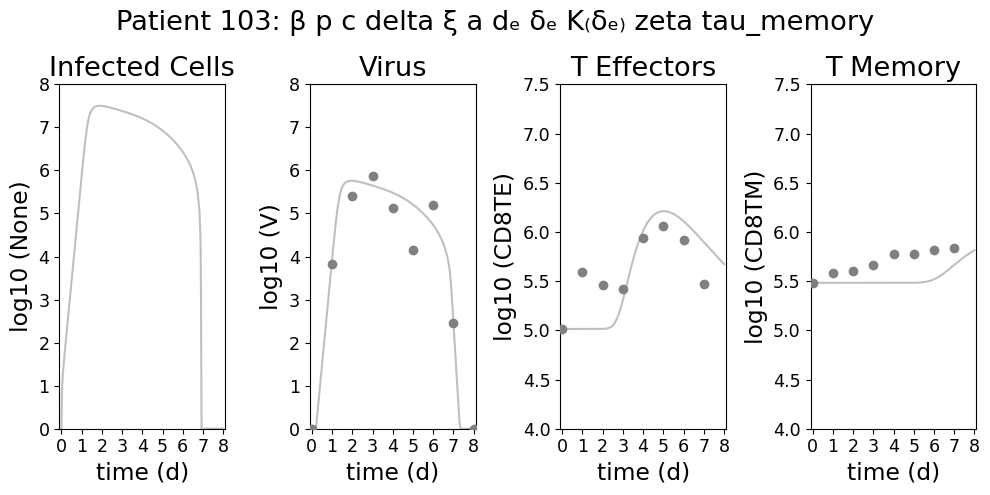

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
ASA best cost: 5.797994900243959
[4.59739626e-05 1.35767673e+00 6.22931985e+01 8.16124317e-01
 1.18250516e+00 1.90625803e+00 1.13486170e+00 7.12800412e-01
 1.60891486e+03 4.07196312e-02 6.07938978e-01]
Results saved to sql/Draft_ASA.db.
Parameter beta: 5.79524703970357e-05
Parameter p: 1.3618974954955152
Parameter c: 62.29312505249573
Parameter delta: 0.8277917994130575
Parameter xi: 1.1845719889627753
Parameter a: 1.913973079206361
Parameter d_E: 1.1339281088429558
Parameter delta_E: 0.7160958857757846
Parameter K_delta_E: 1608.9148615430174
Parameter zeta: 0.041205627569403755
Parameter tau_memory: 0.6079086269851346


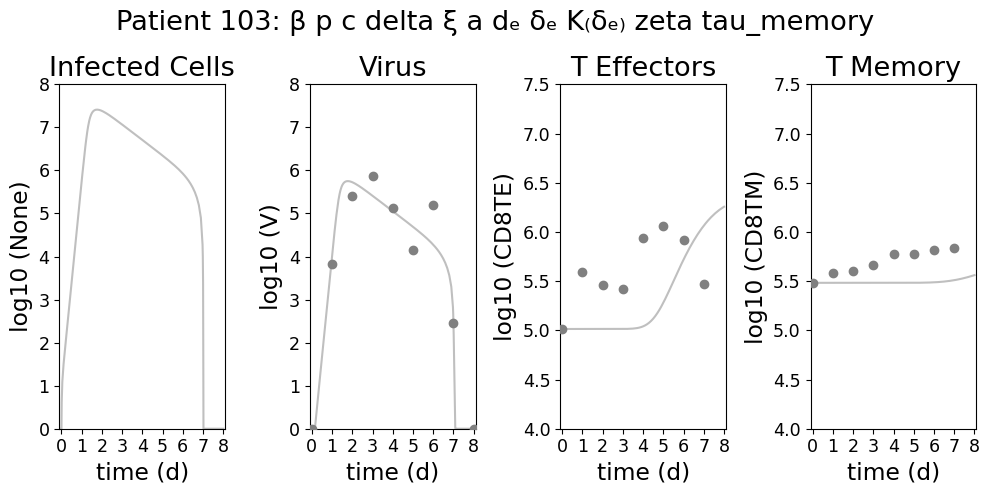

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
ASA best cost: 3.8364084073247247
[7.41909880e-05 9.21242685e-01 4.19994767e+01 8.59567905e-01
 2.33209955e-01 8.08124554e+00 6.75621124e-01 6.14882332e-01
 1.34813798e+02 2.15116697e-01 7.66250940e-01]
Results saved to sql/Draft_ASA.db.
Parameter beta: 5.162780169455927e-05
Parameter p: 0.918172193441695
Parameter c: 42.00040004526476
Parameter delta: 0.8767246264537771
Parameter xi: 0.2534330574583962
Parameter a: 8.079949080224536
Parameter d_E: 0.6745906103890325
Parameter delta_E: 0.6247820440023495
Parameter K_delta_E: 134.8137978709017
Parameter zeta: 0.21434980833874986
Parameter tau_memory: 0.7668390139522304


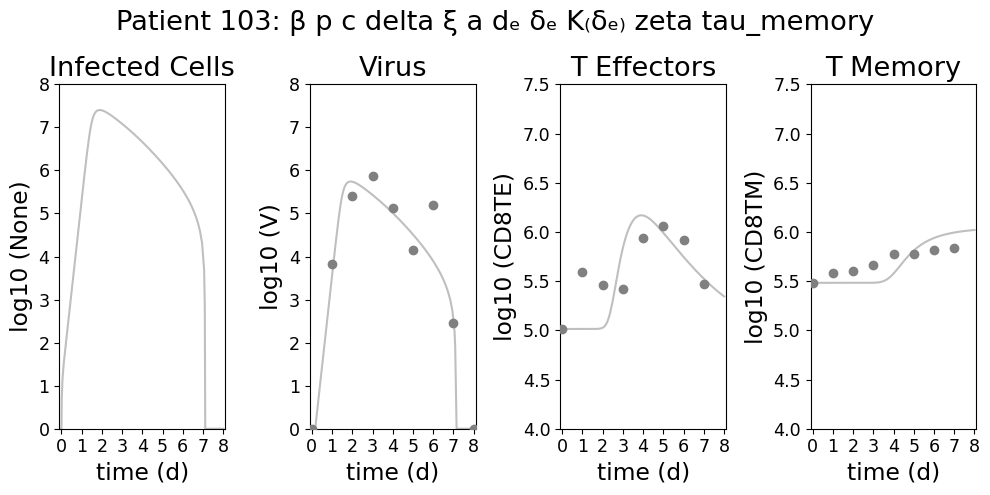

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
ASA best cost: 5.183083335973576
[7.06029600e-05 1.72250875e-01 3.92829458e+00 6.61493127e-01
 4.65070165e-01 3.72041016e+00 1.52373238e+00 2.95586663e+00
 1.02622339e+04 1.13835012e-01 2.44603961e+00]
Results saved to sql/Draft_ASA.db.
Parameter beta: 7.998883271125393e-05
Parameter p: 0.18299065903699377
Parameter c: 4.0332822472586045
Parameter delta: 0.6716983048359702
Parameter xi: 0.47549000474687064
Parameter a: 3.727272535963163
Parameter d_E: 1.52425285053558
Parameter delta_E: 2.9542717720858707
Parameter K_delta_E: 10262.233857079866
Parameter zeta: 0.11372153999895661
Parameter tau_memory: 2.4466449829852777


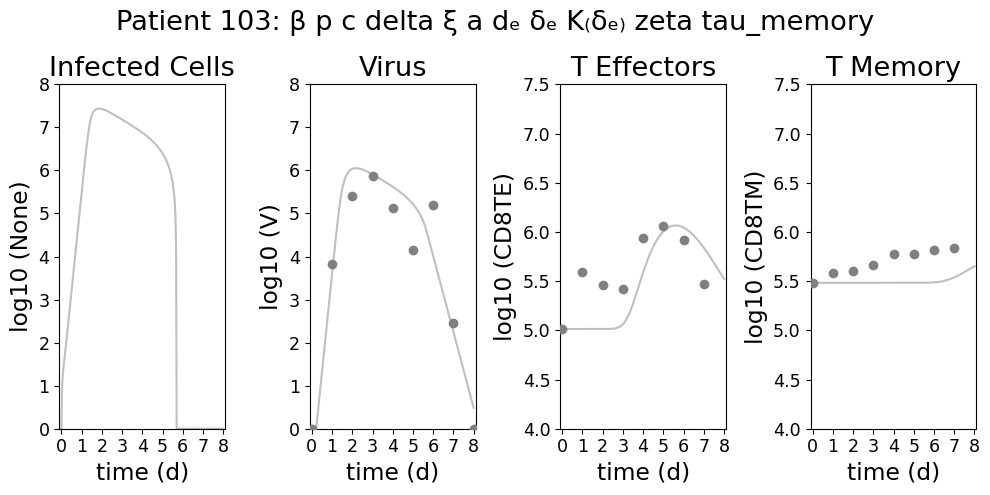

Iteration 0
Iteration 1000


KeyboardInterrupt: 

In [4]:
# Individual Fits ASA

parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=2.1E4, u_lim=1.7E5, method='file', space='normal'),
    M0=Parameter(name='M0', val=1E4, l_lim=2E4, u_lim=3E5, method='file', space='normal'),
    ME=Parameter(name='ME', val=0, l_lim=2E4, u_lim=3E5, method='fixed', space='normal'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=8E7, method='fixed', space='normal'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='normal'), 
    beta=Parameter(name='beta', val=6.2E-5, l_lim=1E-6, u_lim=1E-3, method='fixed', space='normal'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='normal'), 
    p=Parameter(name='p', val=1.0, l_lim=0.1, u_lim=10, method='fixed', space='normal'), 
    c=Parameter(name='c', val=9.4, l_lim=1.0, u_lim=100, method='fixed', space='normal'), 
    delta=Parameter(name='delta', val=0.21, l_lim=0.1, u_lim=10, method='fixed', space='normal'),
    xi=Parameter(name='xi', val=2.6E4, l_lim=0.1, u_lim=10, method='fixed', space='normal'), 
    K_E=Parameter(name='K_E', val=8.1E5, l_lim=1E2, u_lim=1E6, method='fixed', space='normal'),
    a=Parameter(name='a', val=5, l_lim=0.1, u_lim=10, method='fixed', space='normal'), 
    d_E=Parameter(name='d_E', val=1.0, l_lim=0.4, u_lim=2, method='fixed', space='normal'),
    delta_E=Parameter(name='delta_E', val=1.9, l_lim=0.1, u_lim=10, method='fixed', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=434, l_lim=1E2, u_lim=1E5, method='fixed', space='normal'),
    zeta=Parameter(name='zeta', val=0.7, l_lim=0.01, u_lim=1, method='fixed', space='normal'),
    eta=Parameter(name='eta', val=0.22, l_lim=1, u_lim=100, method='fixed', space='normal'), #2.7 for TEMs
    K_I1=Parameter(name='K_I1', val=10000, l_lim=1E2, u_lim=1E6, method='fixed', space='normal'),
    tau_m=Parameter(name='tau_m', val=3.5, l_lim=0.5, u_lim=3, method='fixed', space='normal'),
    tau_e=Parameter(name='tau_e', val=3.6, l_lim=0.5, u_lim=3, method='fixed', space='normal'),
    alphaone=Parameter(name='alphaone', val=4.2651E-7, l_lim=0.1, u_lim=10, method='fixed', space='normal'), 
    alphatwo=Parameter(name='alphatwo', val=8.6536E-8, l_lim=0.1, u_lim=10, method='fixed', space='normal'), 
)

t_span = (0, 8)
patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
for target in [103]:
    for i in range(10):
        results = patients.optimize_parameters(method='ASA', opt_target=target, 
                                            iter=10000, verbose=True, path='Draft_ASA')

        plot(results, subplot_configuration, t_span, figsize=(10,5))

Parameter 'M0' for ID Population is missing in the parameter file. Falling back to original values.
103 Dual Annealing with 10 iterations.
103 polish


C:\Users\jorda\AppData\Local\Temp\ipykernel_20292\334814853.py:705: OptimizeWarning: Unknown solver options: xatol, fatol
  result = minimize(


Results saved to sql/Myers_test3.db.
Parameter beta: 0.000999301922955622
Parameter p: 1.2220807729407959
Parameter c: 1.0596078571161904
Parameter delta: 6.126259653755976
Parameter xi: 99872.09746261867
Parameter K_E: 10109.89349538782
Parameter d_E: 0.4006816093848908
Parameter delta_E: 2.5399226143798255
Parameter zeta: 0.08211204156163818
Parameter eta: 9.99441226995693e-07
Parameter tau_m: 0.5002331094181307
Parameter tau_e: 3.1005660723212642


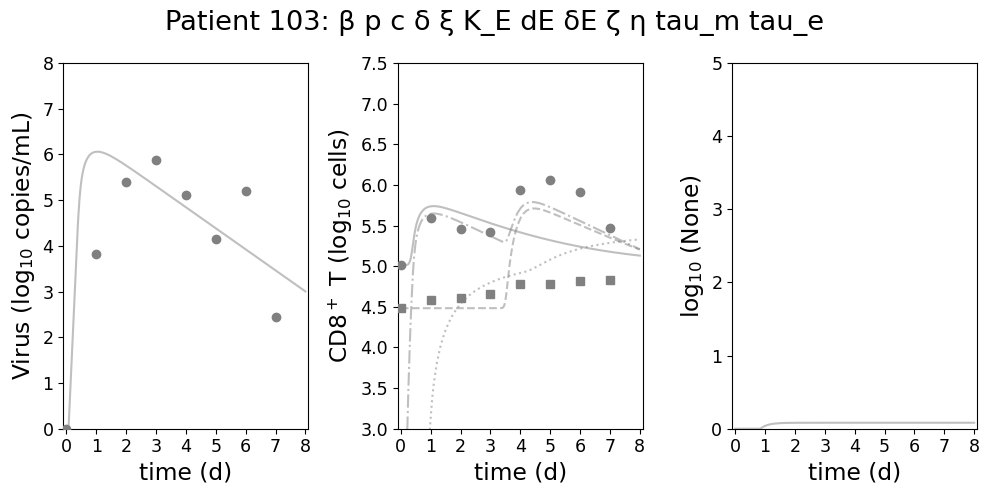

107 Dual Annealing with 10 iterations.


KeyboardInterrupt: 

In [37]:
# Individual Fits p
parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=2.1E4, u_lim=1.7E5, method='file', space='normal'),
    M0=Parameter(name='M0', val=1E4, l_lim=2E4, u_lim=3E5, method='file', space='normal'),
    ME=Parameter(name='ME', val=0, l_lim=2E4, u_lim=3E5, method='fixed', space='normal'),
    T0=Parameter(name='T0', val=1E7, l_lim=1E7, u_lim=8E7, method='fixed', space='normal'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='normal'), 
    beta=Parameter(name='beta', val=6.2E-5, l_lim=1E-6, u_lim=1E-3, method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='normal'), 
    p=Parameter(name='p', val=1.0, l_lim=0.1, u_lim=10, method='fit', space='log10'), 
    c=Parameter(name='c', val=9.4, l_lim=1.0, u_lim=100, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=0.21, l_lim=0.1, u_lim=10, method='fit', space='normal'),
    xi=Parameter(name='xi', val=2.6E4, l_lim=1E3, u_lim=1E5, method='fit', space='log10'), 
    K_E=Parameter(name='K_E', val=8.1E5, l_lim=1E4, u_lim=1E6, method='fit', space='normal'),
    a=Parameter(name='a', val=5, l_lim=0.1, u_lim=10, method='fixed', space='normal'), 
    d_E=Parameter(name='d_E', val=1.0, l_lim=0.4, u_lim=2, method='fit', space='normal'),
    delta_E=Parameter(name='delta_E', val=1.9, l_lim=0.1, u_lim=10, method='fit', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=434, l_lim=1E2, u_lim=1E5, method='fixed', space='log10'),
    zeta=Parameter(name='zeta', val=0.22, l_lim=0.01, u_lim=1, method='fit', space='normal'),
    eta=Parameter(name='eta', val=2.5E-7, l_lim=1E-8, u_lim=1E-6, method='fit', space='log10'), #2.7 for TEMs
    K_I1=Parameter(name='K_I1', val=10000, l_lim=1E2, u_lim=1E6, method='fixed', space='normal'),
    tau_m=Parameter(name='tau_m', val=3.5, l_lim=0.5, u_lim=5, method='fit', space='normal'),
    tau_e=Parameter(name='tau_e', val=3.6, l_lim=0.5, u_lim=5, method='fit', space='normal'),
    alphaone=Parameter(name='alphaone', val=4.2651E-7, l_lim=0.1, u_lim=10, method='fixed', space='normal'), 
    alphatwo=Parameter(name='alphatwo', val=8.6536E-8, l_lim=0.1, u_lim=10, method='fixed', space='normal'), 
)

t_span = (0, 8)
df = pd.read_excel("../Data/Rahil_2020/Table8_Healed.xlsx", sheet_name='Main')
df_Rahil = df[['VOLUNTEER', 'DAY', 'V', 'IFNG', 'CD8TE', 'CD8TM']]
df_Rahil = df_Rahil.loc[df_Rahil['DAY'] < 9]

patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
for target in shedders:
    results = patients.optimize_parameters(method='dual_annealing', opt_target=target, 
                                        iter=10, verbose=True, path='Myers_test3')
    
    patient_color = color_mapping.get(target, 'black') 
    plot(results, subplot_configuration, t_span, figsize=(10,5), patient_color=patient_color)

Population Differential Evolution with 25 generations.


C:\Users\jorda\AppData\Local\Temp\ipykernel_13048\925991952.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pid_df['VOLUNTEER'] = 'Population'


differential_evolution step 1: f(x)= 302.2950784930156
differential_evolution step 2: f(x)= 295.2769219211649
differential_evolution step 3: f(x)= 295.2769219211649
differential_evolution step 4: f(x)= 290.16018423073905
differential_evolution step 5: f(x)= 290.16018423073905
differential_evolution step 6: f(x)= 290.16018423073905
differential_evolution step 7: f(x)= 288.5637428316397
differential_evolution step 8: f(x)= 288.5637428316397
differential_evolution step 9: f(x)= 288.3175555066817
differential_evolution step 10: f(x)= 288.1196954388746
differential_evolution step 11: f(x)= 288.1196954388746
differential_evolution step 12: f(x)= 288.0784285160597
differential_evolution step 13: f(x)= 288.0695876171901
Polishing solution with 'L-BFGS-B'
Results saved to sql/Rahil_p.db.
Parameter E0: 125755.78957187336
Parameter M0: 7498.224720353563
Parameter beta: 4.886050086483583e-05
Parameter p: 2.837508917254666
Parameter c: 141.1560875872953
Parameter delta: 1.3333634890776214
Parameter

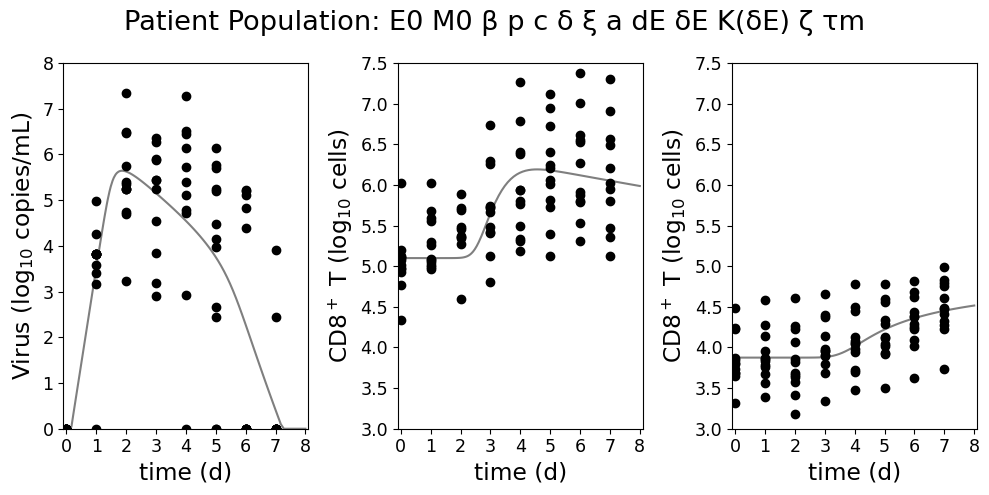

In [3]:
# Cohort fit p
parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=46934, u_lim=270450, method='fit', space='log10'),
    M0=Parameter(name='M0', val=1E4, l_lim=3529, u_lim=14958, method='fit', space='log10'),
    ME=Parameter(name='ME', val=0, l_lim=2E3, u_lim=3E4, method='fixed', space='log10'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=8E7, method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=1E-6, u_lim=1E-3, method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=1, l_lim=0.05, u_lim=10, method='fit', space='normal'), 
    c=Parameter(name='c', val=10, l_lim=5.0, u_lim=500, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=3, l_lim=0.05, u_lim=5, method='fit', space='log10'),
    xi=Parameter(name='xi', val=1.0, l_lim=0.05, u_lim=10, method='fit', space='log10'), 
    a=Parameter(name='a', val=5, l_lim=1.0, u_lim=10, method='fit', space='log10'), 
    d_E=Parameter(name='d_E', val=0.5, l_lim=0.05, u_lim=2, method='fit', space='log10'),
    delta_E=Parameter(name='delta_E', val=.75, l_lim=0.05, u_lim=10, method='fit', space='log10'),
    K_delta_E=Parameter(name='K_delta_E', val=1.9E4, l_lim=1E2, u_lim=1E5, method='fit', space='log10'),
    zeta=Parameter(name='zeta', val=0.07, l_lim=5E-4, u_lim=1E-1, method='fit', space='log10'),
    eta=Parameter(name='eta', val=0, l_lim=1, u_lim=100, method='fixed', space='log10'), 
    K_I1=Parameter(name='K_I1', val=10000, l_lim=1E2, u_lim=1E6, method='fixed', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=2.5, l_lim=0.25, u_lim=0.6, method='fit', space='normal'),
)
t_span = (0, 8)

df = pd.read_excel("../Data/Rahil_2020/Table8_Healed.xlsx", sheet_name='Main')
df_Rahil = df[['VOLUNTEER', 'DAY', 'V', 'IFNG', 'CD8TE', 'CD8TM']]
df_Rahil = df_Rahil.loc[df_Rahil['DAY'] < 9]

patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
for target in ['Population']:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=25, verbose=True, path='Rahil_p')

    plot(results, subplot_configuration, t_span, figsize=(10,5))

Parameter 'M0' for ID Population is missing in the parameter file. Falling back to original values.
103 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 3.502776905012442
differential_evolution step 2: f(x)= 3.502776905012442
differential_evolution step 3: f(x)= 3.020288605510105
differential_evolution step 4: f(x)= 3.020288605510105
differential_evolution step 5: f(x)= 3.020288605510105
differential_evolution step 6: f(x)= 2.4369644928116125
differential_evolution step 7: f(x)= 2.4369644928116125
differential_evolution step 8: f(x)= 2.4347239613457274
differential_evolution step 9: f(x)= 2.349360163300605
differential_evolution step 10: f(x)= 2.145823828715434
differential_evolution step 11: f(x)= 2.145823828715434
differential_evolution step 12: f(x)= 2.145823828715434
differential_evolution step 13: f(x)= 2.145823828715434
differential_evolution step 14: f(x)= 2.121409130310078
differential_evolution step 15: f(x)= 2.0736223641151996
differential_evol

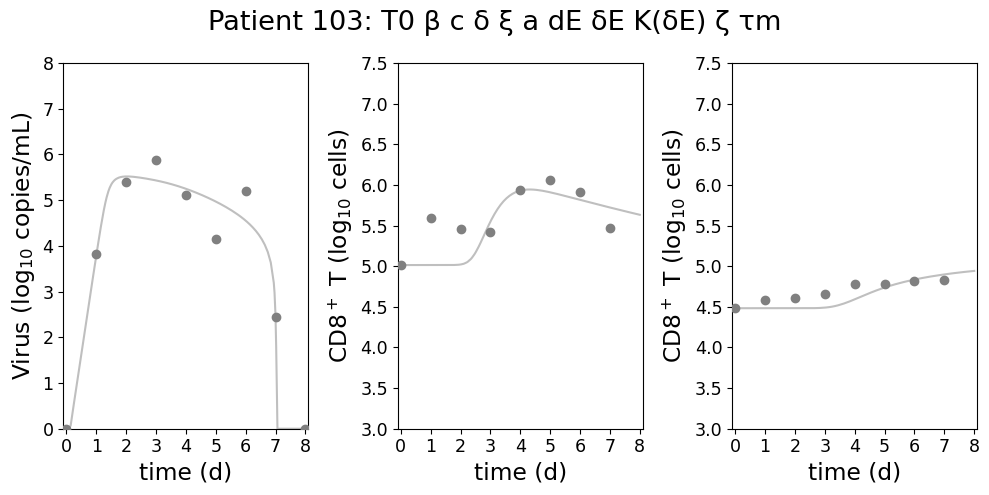

107 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 2.3571643574335446
differential_evolution step 2: f(x)= 2.1848623980809507
differential_evolution step 3: f(x)= 2.0400607752179503
differential_evolution step 4: f(x)= 1.582056423183586
differential_evolution step 5: f(x)= 1.582056423183586
differential_evolution step 6: f(x)= 1.367338104251729
differential_evolution step 7: f(x)= 1.367338104251729
differential_evolution step 8: f(x)= 1.367338104251729
differential_evolution step 9: f(x)= 1.367338104251729
differential_evolution step 10: f(x)= 1.367338104251729
differential_evolution step 11: f(x)= 1.3495567422606258
differential_evolution step 12: f(x)= 1.348102077683763
differential_evolution step 13: f(x)= 1.348102077683763
differential_evolution step 14: f(x)= 1.348102077683763
differential_evolution step 15: f(x)= 1.348102077683763
differential_evolution step 16: f(x)= 1.348102077683763
differential_evolution step 17: f(x)= 1.3433651282222585
diff

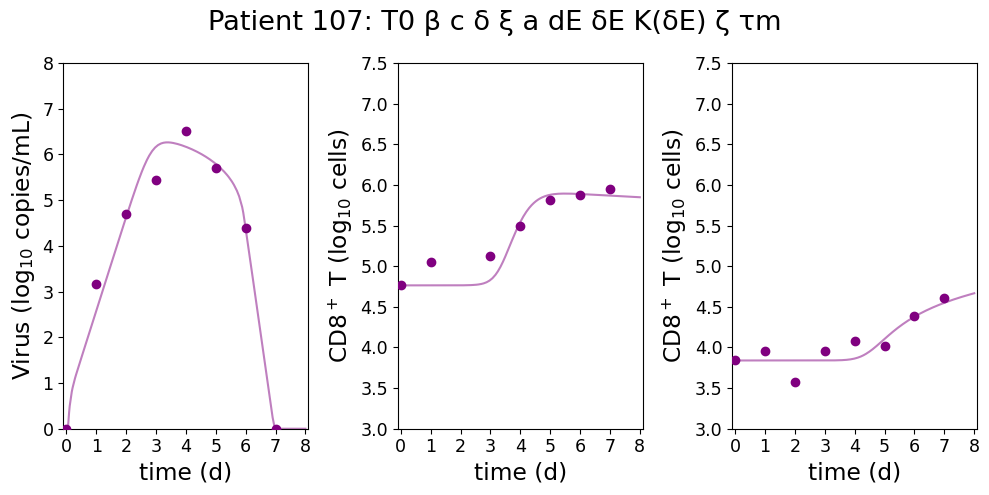

110 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 1.5476421877596886
differential_evolution step 2: f(x)= 0.35323417601146656
differential_evolution step 3: f(x)= 0.35323417601146656
differential_evolution step 4: f(x)= 0.35323417601146656
differential_evolution step 5: f(x)= 0.35323417601146656
differential_evolution step 6: f(x)= 0.27911545356777984
differential_evolution step 7: f(x)= 0.27911545356777984
differential_evolution step 8: f(x)= 0.2622949758617368
differential_evolution step 9: f(x)= 0.2622949758617368
differential_evolution step 10: f(x)= 0.2622949758617368
differential_evolution step 11: f(x)= 0.21077530955991663
differential_evolution step 12: f(x)= 0.1975411478091661
differential_evolution step 13: f(x)= 0.14667207207490557
differential_evolution step 14: f(x)= 0.14667207207490557
differential_evolution step 15: f(x)= 0.13893941644115734
differential_evolution step 16: f(x)= 0.1321853342160029
differential_evolution step 17: f(x)= 0

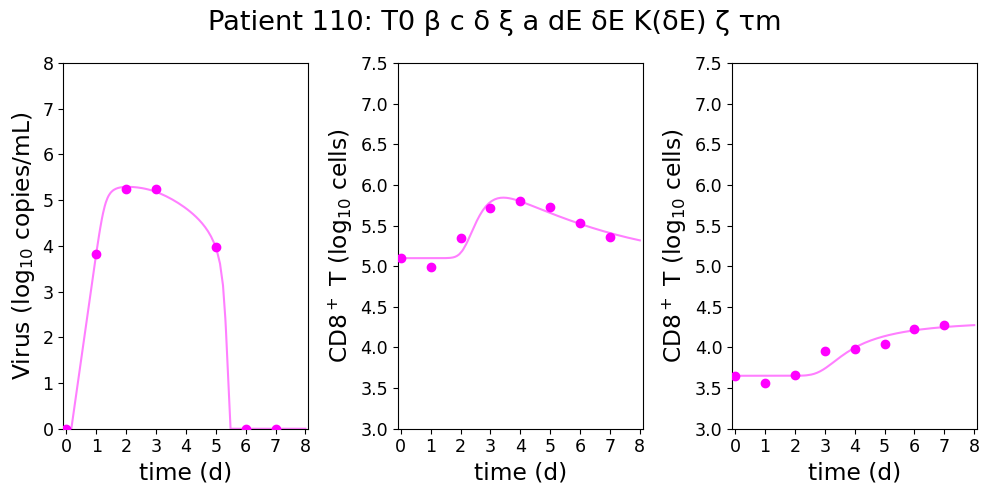

111 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 4.3712072137565405
differential_evolution step 2: f(x)= 4.3712072137565405
differential_evolution step 3: f(x)= 2.2158048078666015
differential_evolution step 4: f(x)= 2.2158048078666015
differential_evolution step 5: f(x)= 2.2158048078666015
differential_evolution step 6: f(x)= 2.1651251115130417
differential_evolution step 7: f(x)= 1.979030727819584
differential_evolution step 8: f(x)= 1.8379369919861268
differential_evolution step 9: f(x)= 1.7306271810010565
differential_evolution step 10: f(x)= 1.7306271810010565
differential_evolution step 11: f(x)= 1.7306271810010565
differential_evolution step 12: f(x)= 1.7306271810010565
differential_evolution step 13: f(x)= 1.7205834407757916
differential_evolution step 14: f(x)= 1.7035202859472267
differential_evolution step 15: f(x)= 1.7035202859472267
differential_evolution step 16: f(x)= 1.7035202859472267
differential_evolution step 17: f(x)= 1.7035202859

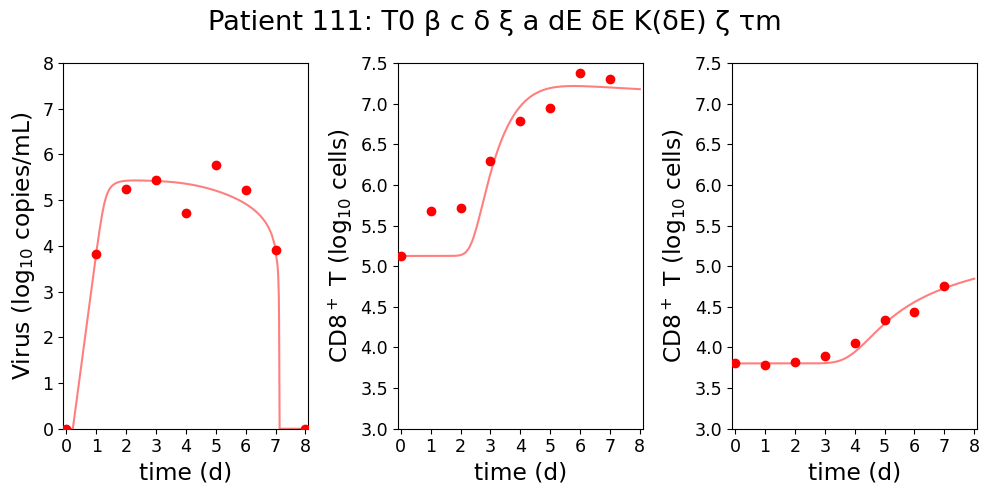

112 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 3.475710517989009
differential_evolution step 2: f(x)= 2.1559348194611028
differential_evolution step 3: f(x)= 2.1559348194611028
differential_evolution step 4: f(x)= 2.1559348194611028
differential_evolution step 5: f(x)= 1.9855908329996013
differential_evolution step 6: f(x)= 1.6109405886295716
differential_evolution step 7: f(x)= 1.6109405886295716
differential_evolution step 8: f(x)= 1.5350487972223497
differential_evolution step 9: f(x)= 1.5350487972223497
differential_evolution step 10: f(x)= 1.4352435226664084
differential_evolution step 11: f(x)= 1.341487137597142
differential_evolution step 12: f(x)= 1.341487137597142
differential_evolution step 13: f(x)= 1.341487137597142
differential_evolution step 14: f(x)= 1.2690335406374063
differential_evolution step 15: f(x)= 1.2690335406374063
differential_evolution step 16: f(x)= 1.2690335406374063
differential_evolution step 17: f(x)= 1.2690335406374

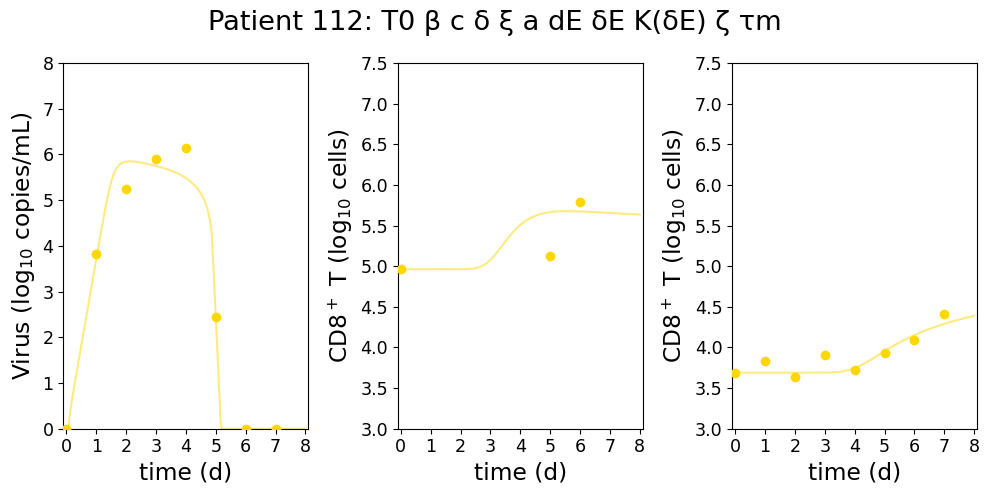

204 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 2.6105076121516775
differential_evolution step 2: f(x)= 1.9130781398133299
differential_evolution step 3: f(x)= 1.5004653242625903
differential_evolution step 4: f(x)= 0.7782996650155254
differential_evolution step 5: f(x)= 0.7782996650155254
differential_evolution step 6: f(x)= 0.7750824291185625
differential_evolution step 7: f(x)= 0.7577220596724186
differential_evolution step 8: f(x)= 0.7577220596724186
differential_evolution step 9: f(x)= 0.7096438793942674
differential_evolution step 10: f(x)= 0.7025403130836163
differential_evolution step 11: f(x)= 0.6723992678353852
differential_evolution step 12: f(x)= 0.6723992678353852
differential_evolution step 13: f(x)= 0.6723992678353852
differential_evolution step 14: f(x)= 0.6673791684627387
differential_evolution step 15: f(x)= 0.6460904011184366
differential_evolution step 16: f(x)= 0.6405481458850962
differential_evolution step 17: f(x)= 0.637715640

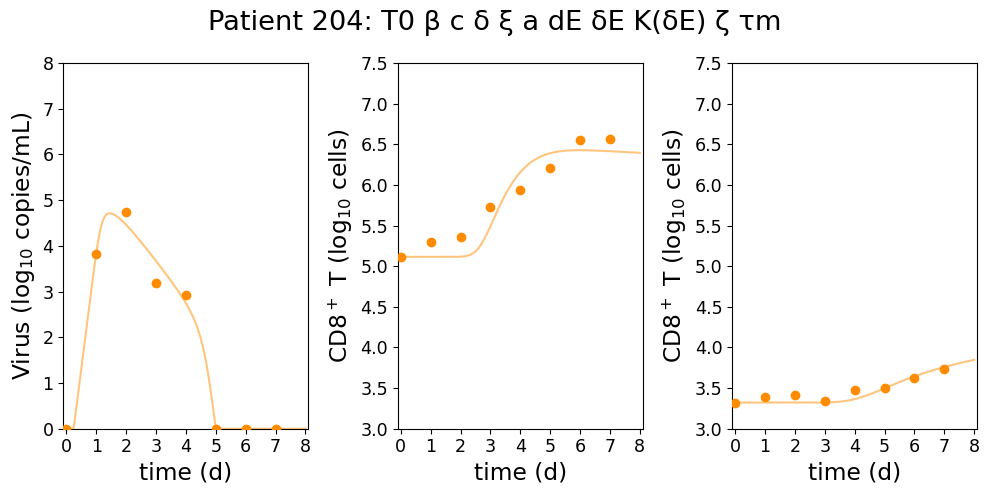

207 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 1.3111899363539452
differential_evolution step 2: f(x)= 1.0390213083618323
differential_evolution step 3: f(x)= 0.7293381074564654
differential_evolution step 4: f(x)= 0.7167396697324169
differential_evolution step 5: f(x)= 0.7167396697324169
differential_evolution step 6: f(x)= 0.6577382945770088
differential_evolution step 7: f(x)= 0.5645223334314055
differential_evolution step 8: f(x)= 0.5645223334314055
differential_evolution step 9: f(x)= 0.5546946866530704
differential_evolution step 10: f(x)= 0.5546946866530704
differential_evolution step 11: f(x)= 0.5546946866530704
differential_evolution step 12: f(x)= 0.5546946866530704
differential_evolution step 13: f(x)= 0.5540747261130443
differential_evolution step 14: f(x)= 0.5540747261130443
differential_evolution step 15: f(x)= 0.541147323173989
differential_evolution step 16: f(x)= 0.5373979557183308
differential_evolution step 17: f(x)= 0.5373413462

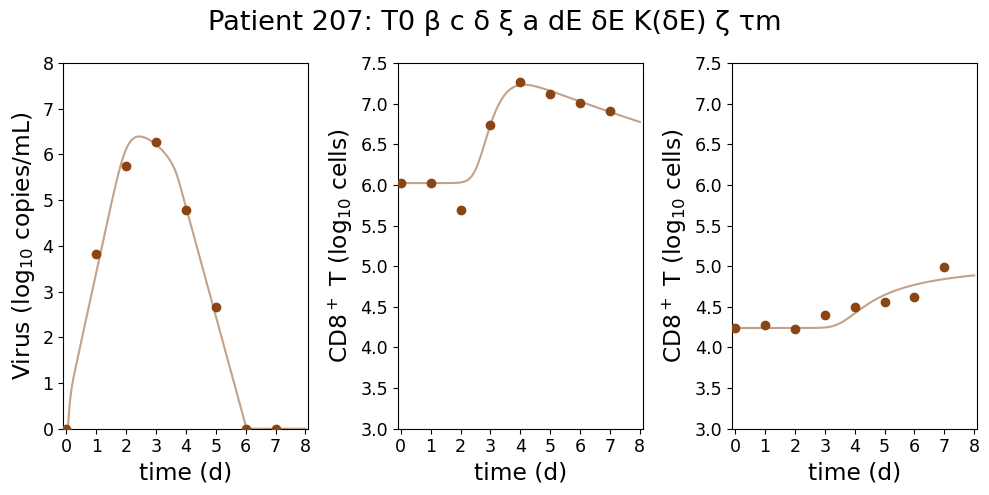

302 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 2.4691442468403344
differential_evolution step 2: f(x)= 2.422477129390364
differential_evolution step 3: f(x)= 2.011960554760665
differential_evolution step 4: f(x)= 1.8452811950741104
differential_evolution step 5: f(x)= 1.8452811950741104
differential_evolution step 6: f(x)= 1.319943059679695
differential_evolution step 7: f(x)= 1.319943059679695
differential_evolution step 8: f(x)= 1.1572112197077764
differential_evolution step 9: f(x)= 0.8999493300674298
differential_evolution step 10: f(x)= 0.8999493300674298
differential_evolution step 11: f(x)= 0.8999493300674298
differential_evolution step 12: f(x)= 0.8322171809289044
differential_evolution step 13: f(x)= 0.7468385064724579
differential_evolution step 14: f(x)= 0.7468385064724579
differential_evolution step 15: f(x)= 0.7468385064724579
differential_evolution step 16: f(x)= 0.7468385064724579
differential_evolution step 17: f(x)= 0.7468385064724

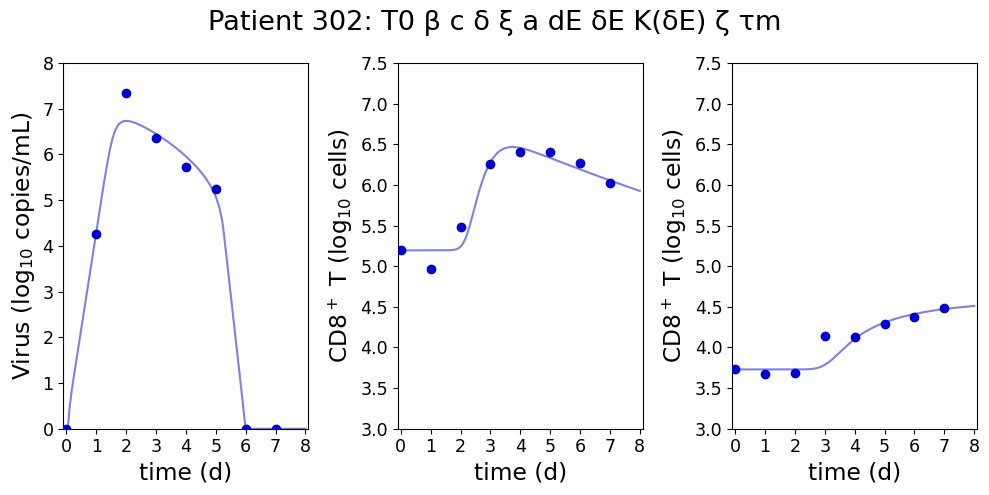

307 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 2.5239519834803668
differential_evolution step 2: f(x)= 2.3875881374961314
differential_evolution step 3: f(x)= 1.8405069825972693
differential_evolution step 4: f(x)= 1.0399434479654468
differential_evolution step 5: f(x)= 1.0241400669223544
differential_evolution step 6: f(x)= 1.0241400669223544
differential_evolution step 7: f(x)= 0.8381114181977796
differential_evolution step 8: f(x)= 0.8381114181977796
differential_evolution step 9: f(x)= 0.8325423670308728
differential_evolution step 10: f(x)= 0.820485866167668
differential_evolution step 11: f(x)= 0.8034456240053311
differential_evolution step 12: f(x)= 0.8034347269572792
differential_evolution step 13: f(x)= 0.8014621303765634
differential_evolution step 14: f(x)= 0.8014621303765634
differential_evolution step 15: f(x)= 0.8014621303765634
differential_evolution step 16: f(x)= 0.8014621303765634
differential_evolution step 17: f(x)= 0.8014621303

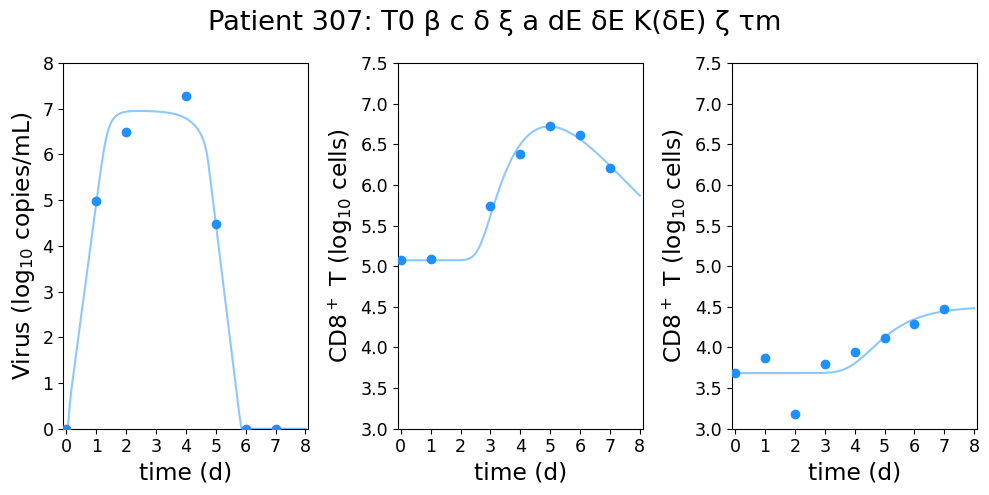

308 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 4.115983771509579
differential_evolution step 2: f(x)= 2.5841555959341145
differential_evolution step 3: f(x)= 2.5841555959341145
differential_evolution step 4: f(x)= 2.5841555959341145
differential_evolution step 5: f(x)= 2.5676988221971566
differential_evolution step 6: f(x)= 2.487265470885694
differential_evolution step 7: f(x)= 2.487265470885694
differential_evolution step 8: f(x)= 2.4052938717068155
differential_evolution step 9: f(x)= 2.4052938717068155
differential_evolution step 10: f(x)= 2.3448721622309705
differential_evolution step 11: f(x)= 2.3448721622309705
differential_evolution step 12: f(x)= 2.3448721622309705
differential_evolution step 13: f(x)= 2.2896885675898835
differential_evolution step 14: f(x)= 2.2896885675898835
differential_evolution step 15: f(x)= 2.2896885675898835
differential_evolution step 16: f(x)= 2.2896885675898835
differential_evolution step 17: f(x)= 2.288495778777

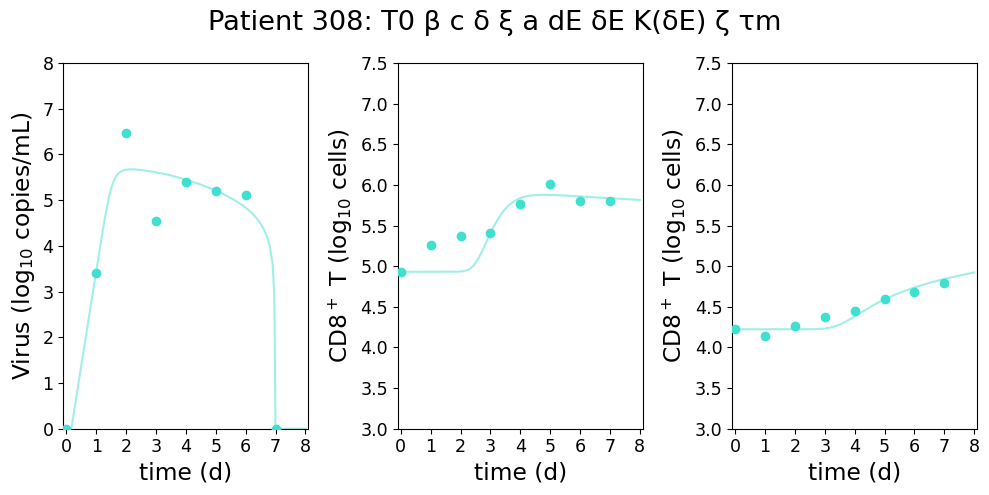

311 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 2.7288124733014723
differential_evolution step 2: f(x)= 2.3468212563710416
differential_evolution step 3: f(x)= 2.3468212563710416
differential_evolution step 4: f(x)= 1.8055341488541483
differential_evolution step 5: f(x)= 1.6802303540164265
differential_evolution step 6: f(x)= 1.5148276325926027
differential_evolution step 7: f(x)= 1.4889429792424833
differential_evolution step 8: f(x)= 1.4282506824831263
differential_evolution step 9: f(x)= 1.4237356165999577
differential_evolution step 10: f(x)= 1.4237356165999577
differential_evolution step 11: f(x)= 1.390425688367554
differential_evolution step 12: f(x)= 1.3625006855610278
differential_evolution step 13: f(x)= 1.3625006855610278
differential_evolution step 14: f(x)= 1.3545197706220715
differential_evolution step 15: f(x)= 1.3545197706220715
differential_evolution step 16: f(x)= 1.3545197706220715
differential_evolution step 17: f(x)= 1.3523714903

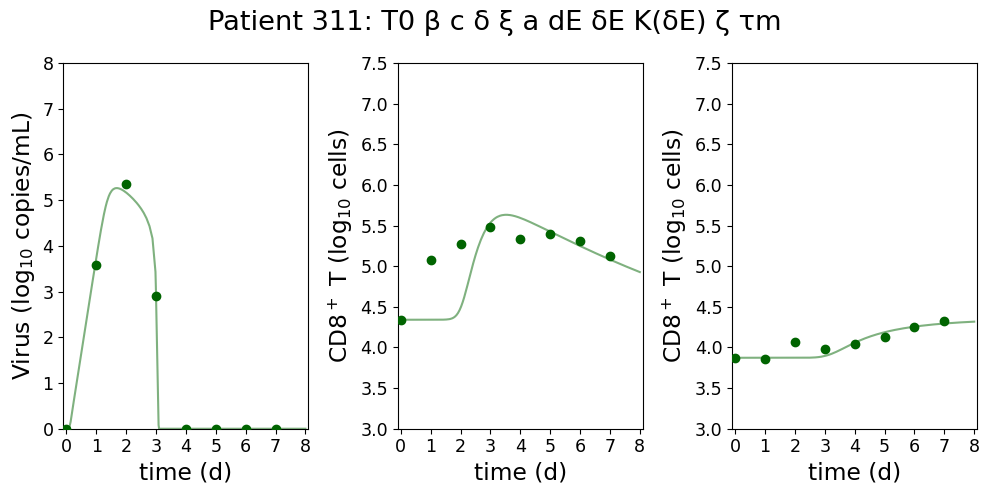

312 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 4.934405134429144
differential_evolution step 2: f(x)= 4.243290494918558
differential_evolution step 3: f(x)= 3.664578819092448
differential_evolution step 4: f(x)= 3.4538004061259873
differential_evolution step 5: f(x)= 3.3027000346192406
differential_evolution step 6: f(x)= 3.281395491767581
differential_evolution step 7: f(x)= 3.127115627109978
differential_evolution step 8: f(x)= 3.127115627109978
differential_evolution step 9: f(x)= 3.127115627109978
differential_evolution step 10: f(x)= 3.123354244570991
differential_evolution step 11: f(x)= 3.117156283759736
differential_evolution step 12: f(x)= 3.110991279585693
differential_evolution step 13: f(x)= 3.106338450115767
differential_evolution step 14: f(x)= 3.102850953092153
differential_evolution step 15: f(x)= 3.102850953092153
differential_evolution step 16: f(x)= 3.102850953092153
differential_evolution step 17: f(x)= 3.102850953092153
differe

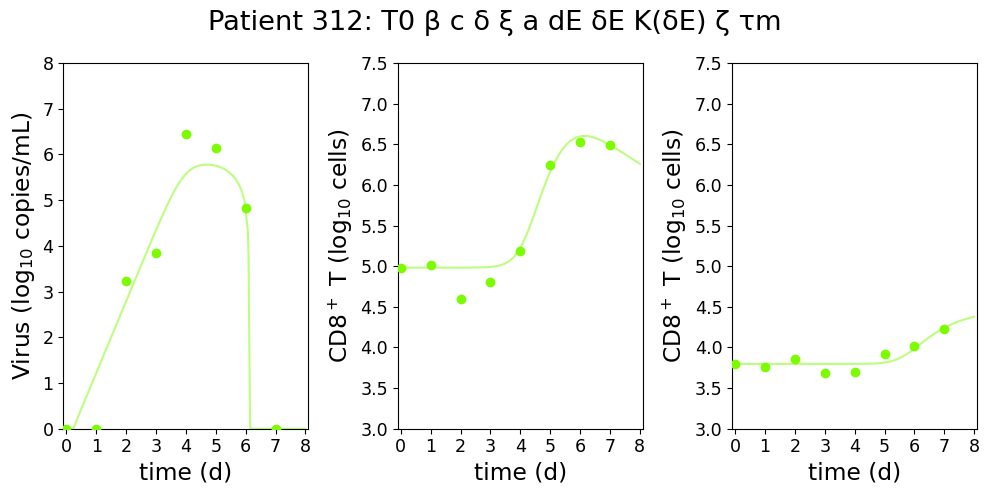

In [5]:
# Individual Fits Dose
parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=46934, u_lim=270450, method='file', space='log10'),
    M0=Parameter(name='M0', val=1E4, l_lim=3529, u_lim=14958, method='file', space='log10'),
    ME=Parameter(name='ME', val=0, l_lim=2E3, u_lim=3E4, method='fixed', space='log10'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=4E7, method='fit', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=1E-6, u_lim=1E-3, method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=2.83, l_lim=0.05, u_lim=10, method='fixed', space='normal'), 
    c=Parameter(name='c', val=10, l_lim=5.0, u_lim=500, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=3, l_lim=0.05, u_lim=5, method='fit', space='log10'),
    xi=Parameter(name='xi', val=1.0, l_lim=0.05, u_lim=10, method='fit', space='log10'), 
    a=Parameter(name='a', val=5, l_lim=1.0, u_lim=10, method='fit', space='log10'), 
    d_E=Parameter(name='d_E', val=0.5, l_lim=0.05, u_lim=2, method='fit', space='log10'),
    delta_E=Parameter(name='delta_E', val=.75, l_lim=0.05, u_lim=10, method='fit', space='log10'),
    K_delta_E=Parameter(name='K_delta_E', val=1.9E4, l_lim=1E2, u_lim=1E5, method='fit', space='log10'),
    zeta=Parameter(name='zeta', val=0.07, l_lim=5E-4, u_lim=1E-1, method='fit', space='log10'),
    eta=Parameter(name='eta', val=0, l_lim=1, u_lim=100, method='fixed', space='log10'), 
    K_I1=Parameter(name='K_I1', val=10000, l_lim=1E2, u_lim=1E6, method='fixed', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=2.5, l_lim=0.25, u_lim=0.6, method='fit', space='normal'),
)
t_span = (0, 8)
df = pd.read_excel("../Data/Rahil_2020/Table8_Healed.xlsx", sheet_name='112Cens')
df_Rahil = df[['VOLUNTEER', 'DAY', 'V', 'IFNG', 'CD8TE', 'CD8TM']]
df_Rahil = df_Rahil.loc[df_Rahil['DAY'] < 9]

patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
for target in shedders:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=25, verbose=True, path='Rahil_Dose')
    
    patient_color = color_mapping.get(target, 'black') 
    plot(results, subplot_configuration, t_span, figsize=(10,5), patient_color=patient_color)

Population Differential Evolution with 25 generations.


C:\Users\jorda\AppData\Local\Temp\ipykernel_13048\925991952.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pid_df['VOLUNTEER'] = 'Population'


differential_evolution step 1: f(x)= 303.35681837994935
differential_evolution step 2: f(x)= 294.6585295307099
differential_evolution step 3: f(x)= 293.27029494694267
differential_evolution step 4: f(x)= 291.86395041836823
differential_evolution step 5: f(x)= 288.6338937138918
differential_evolution step 6: f(x)= 288.6338937138918
differential_evolution step 7: f(x)= 287.72496737716006
differential_evolution step 8: f(x)= 287.3429256382944
differential_evolution step 9: f(x)= 287.3429256382944
differential_evolution step 10: f(x)= 287.07040972771046
differential_evolution step 11: f(x)= 287.07040972771046
differential_evolution step 12: f(x)= 286.8322238033285
differential_evolution step 13: f(x)= 286.7831465251228
Polishing solution with 'L-BFGS-B'
Results saved to sql/Rahil_Dose.db.
Parameter E0: 125955.93282504125
Parameter M0: 7535.822897563735
Parameter T0: 10000000.0
Parameter beta: 6.642187780107478e-05
Parameter c: 53.04626538812169
Parameter delta: 0.9662835154541399
Parameter

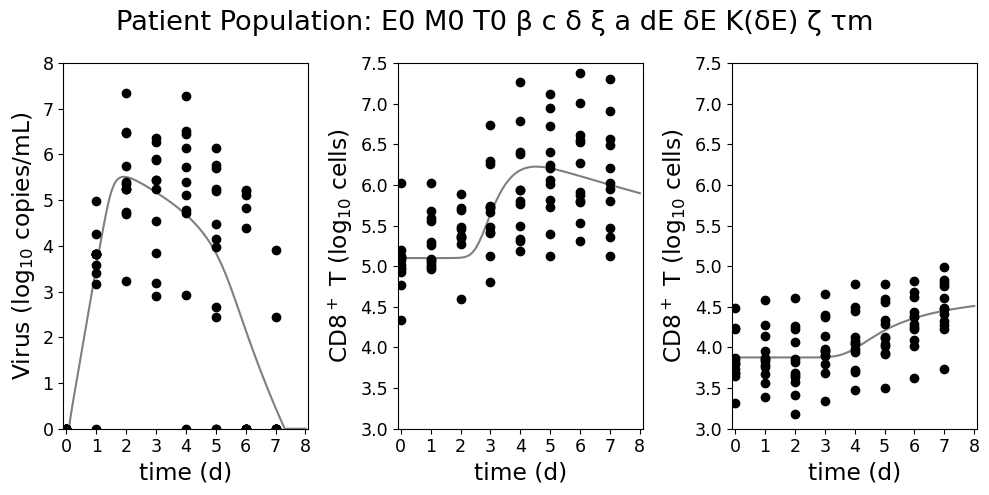

In [6]:
# cohort fit dose 
parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=46934, u_lim=270450, method='fit', space='log10'),
    M0=Parameter(name='M0', val=1E4, l_lim=3529, u_lim=14958, method='fit', space='log10'),
    ME=Parameter(name='ME', val=0, l_lim=2E3, u_lim=3E4, method='fixed', space='log10'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=4E7, method='fit', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=1E-6, u_lim=1E-3, method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=2.83, l_lim=0.05, u_lim=10, method='fixed', space='normal'), 
    c=Parameter(name='c', val=10, l_lim=5.0, u_lim=500, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=3, l_lim=0.05, u_lim=5, method='fit', space='log10'),
    xi=Parameter(name='xi', val=1.0, l_lim=0.05, u_lim=10, method='fit', space='log10'), 
    a=Parameter(name='a', val=5, l_lim=1.0, u_lim=10, method='fit', space='log10'), 
    d_E=Parameter(name='d_E', val=0.5, l_lim=0.05, u_lim=2, method='fit', space='log10'),
    delta_E=Parameter(name='delta_E', val=.75, l_lim=0.05, u_lim=10, method='fit', space='log10'),
    K_delta_E=Parameter(name='K_delta_E', val=1.9E4, l_lim=1E2, u_lim=1E5, method='fit', space='log10'),
    zeta=Parameter(name='zeta', val=0.07, l_lim=5E-4, u_lim=1E-1, method='fit', space='log10'),
    eta=Parameter(name='eta', val=0, l_lim=1, u_lim=100, method='fixed', space='log10'), 
    K_I1=Parameter(name='K_I1', val=10000, l_lim=1E2, u_lim=1E6, method='fixed', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=2.5, l_lim=0.25, u_lim=0.6, method='fit', space='normal'),
)
t_span = (0, 8)

df = pd.read_excel("../Data/Rahil_2020/Table8_Healed.xlsx", sheet_name='Main')
df_Rahil = df[['VOLUNTEER', 'DAY', 'V', 'IFNG', 'CD8TE', 'CD8TM']]
df_Rahil = df_Rahil.loc[df_Rahil['DAY'] < 9]

patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
for target in ['Population']:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=25, verbose=True, path='Rahil_Dose')

    plot(results, subplot_configuration, t_span, figsize=(10,5))

In [19]:
def plot_per_patient_both_sets(
    results,
    results_rechallenge,
    subplot_config,
    t_span=[0, 10],
    figsize=(10,5),
    patient_color='blue',
    save=True
):

    # Prepare x-ticks
    x_ticks = np.arange(t_span[0], t_span[-1] + 1, 1)

    # Determine subplot grid
    n_subplots = len(subplot_config)
    if n_subplots <= 4:
        n_rows, n_cols = 1, n_subplots
    else:
        n_rows = int(np.ceil(np.sqrt(n_subplots)))
        n_cols = int(np.ceil(n_subplots / n_rows))

    # Font sizes
    base_font_size = 14
    title_font_size = base_font_size * 1.4
    label_font_size = base_font_size * 1.2
    tick_font_size = base_font_size * 0.9

    # We'll loop over both sets simultaneously using zip(...)
    # We assume results and results_rechallenge have the same length and matching patients.
    for (res_obj1, patient1), (res_obj2, patient2) in zip(results, results_rechallenge):
        # Typically patient1 and patient2 represent the SAME patient (same ID)
        patient_id = patient1.id  # hopefully patient2.id matches

        # Collect fit parameters from the first scenario (you could combine both if needed)
        fit_parameters = [
            param_name
            for param_name, param in patient1.parameters._parameters.items()
            if param.method == 'fit'
        ]
        fit_params_str = format_fit_params(fit_parameters) if fit_parameters else ""

        # Create figure and subplots for this patient
        fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)
        axs_flat = axs.flatten()

        # Figure title
        title_str = f"Patient {patient_id}: {fit_params_str}"
        fig.suptitle(title_str, fontsize=title_font_size)

        # Plot each subplot
        for i, config in enumerate(subplot_config):
            ax = axs_flat[i]

            # Plot data from the first scenario (results)
            data_keys = config['data_key'] if isinstance(config['data_key'], list) else [config['data_key']]
            markers = ['o', 's', '^', 'D', 'v']
            
            for j, data_key in enumerate(data_keys):
                if data_key:
                    # Filter volunteer data for this patient
                    volunteer_data = patient1.df[
                        patient1.df['VOLUNTEER'] == patient_id
                    ].copy()
                    ax.plot(
                        volunteer_data['DAY'],
                        np.log10(np.maximum(volunteer_data[data_key], 1.0)),
                        marker=markers[j % len(markers)],
                        color=patient_color,
                        linestyle='None',
                        alpha=1.0,
                        zorder=15
                    )

            # Plot model solution from the first scenario (results)
            sol_keys = config['sol_key'] if isinstance(config['sol_key'], list) else [config['sol_key']]
            linestyles = ['-', '--', '-.', ':']
            if patient1.sol:
                sol_t = patient1.sol.t
                for k, sol_key in enumerate(sol_keys):
                    sol_y_raw = patient1.sol.y[sol_key]
                    sol_y = np.log10(np.where(sol_y_raw < 1, 1, sol_y_raw))
                    ax.plot(
                        sol_t,
                        sol_y,
                        color=patient_color,
                        linestyle=linestyles[k % len(linestyles)],
                        alpha=1.0
                    )
            
            # Now plot data + model lines from the second scenario (results_rechallenge) in black
            if patient2.df is not None:
                for j, data_key in enumerate(data_keys):
                    if data_key:
                        volunteer_data = patient2.df[
                            patient2.df['VOLUNTEER'] == patient2.id
                        ].copy()
                        ax.plot(
                            volunteer_data['DAY'],
                            np.log10(np.maximum(volunteer_data[data_key], 1.0)),
                            marker=markers[j % len(markers)],
                            color=patient_color,
                            linestyle='None',
                            alpha=1.0,
                            zorder=15
                        )
            if patient2.sol:
                sol_t = patient2.sol.t
                for k, sol_key in enumerate(sol_keys):
                    sol_y_raw = patient2.sol.y[sol_key]
                    sol_y = np.log10(np.where(sol_y_raw < 1, 1, sol_y_raw))
                    ax.plot(
                        sol_t,
                        sol_y,
                        color='black',
                        linestyle=linestyles[k % len(linestyles)],
                        alpha=1.0
                    )

            # Axis limits, labels, etc.
            if 'ylims' in config and config['ylims']:
                ax.set_ylim(config['ylims'])
            ax.set_xticks(x_ticks)
            ax.set_xlim([t_span[0] - 0.1, t_span[-1] + 0.1])
            ax.set_xlabel('Time (d)', fontsize=label_font_size)
            # Label y-axis based on first data_key (if present)
            if len(data_keys) > 0 and data_keys[0]:
                if 'V' in data_keys:
                    ax.set_ylabel(f'Virus (log$_{{10}}$ copies/mL)', fontsize=label_font_size)
                elif 'CD8TE' in data_keys:
                    ax.set_ylabel(f'CD8$^+$ T (log$_{{10}}$ cells)', fontsize=label_font_size)
                elif 'CD8TM' in data_keys:
                    ax.set_ylabel(f'CD8$^+$ T (log$_{{10}}$ cells)', fontsize=label_font_size)
                else:
                    ax.set_ylabel(f'log$_{{10}}$ ({data_keys[0]})', fontsize=label_font_size)
            ax.tick_params(axis='both', which='major', labelsize=tick_font_size)

        # Hide unused subplots if any
        for extra_ax in axs_flat[len(subplot_config):]:
            extra_ax.set_visible(False)

        plt.tight_layout()

        # Save the figure if desired
        save_dir = os.path.join('plots', f'Patient_{patient_id}')
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'{fit_params_str}.png')
        if save:
            plt.savefig(save_path, bbox_inches='tight')
        plt.show()

No parameters to optimize
No parameters to optimize


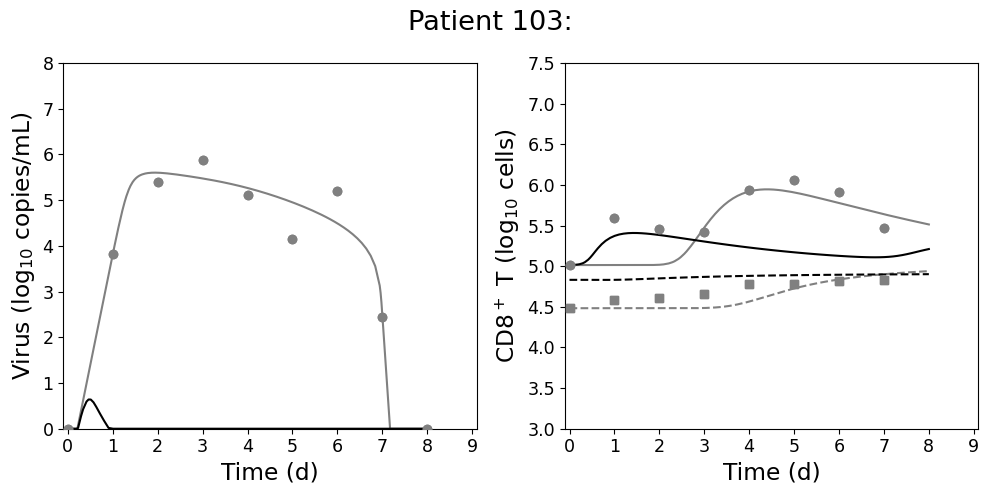

No parameters to optimize
No parameters to optimize


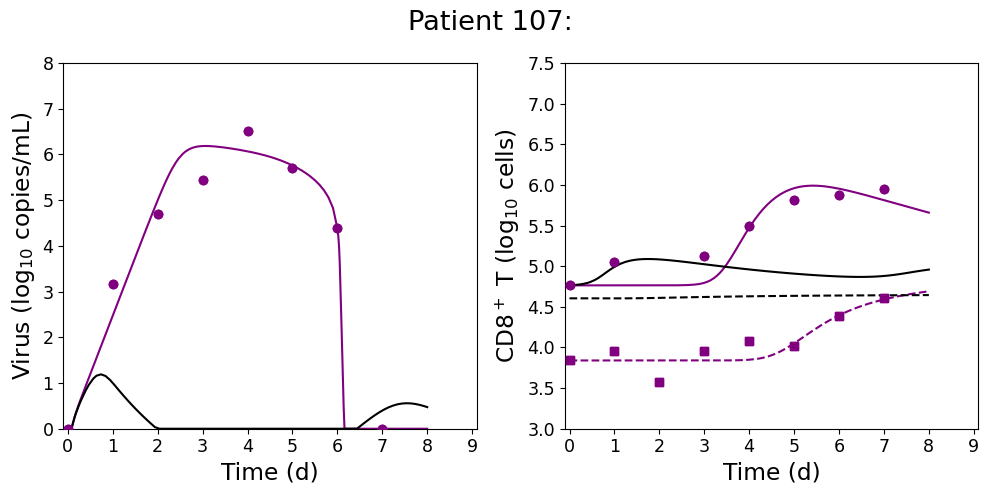

No parameters to optimize
No parameters to optimize


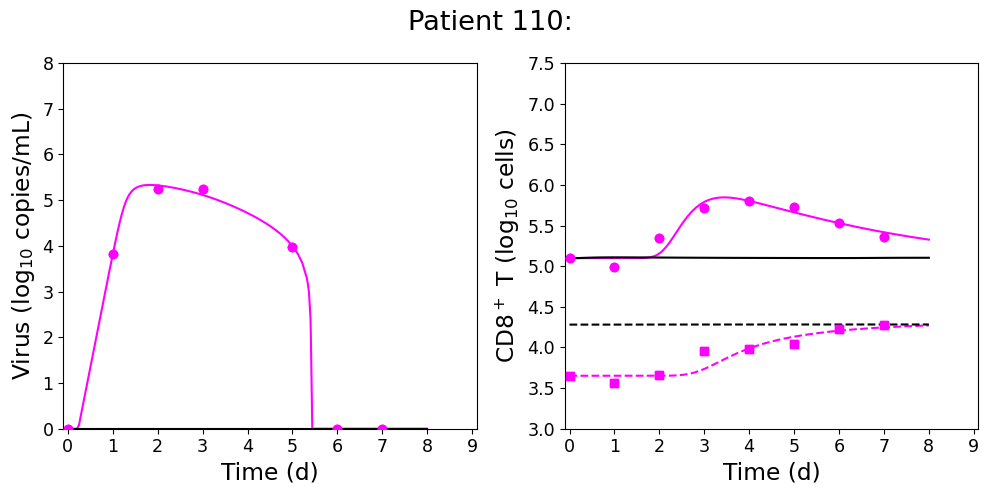

No parameters to optimize
No parameters to optimize


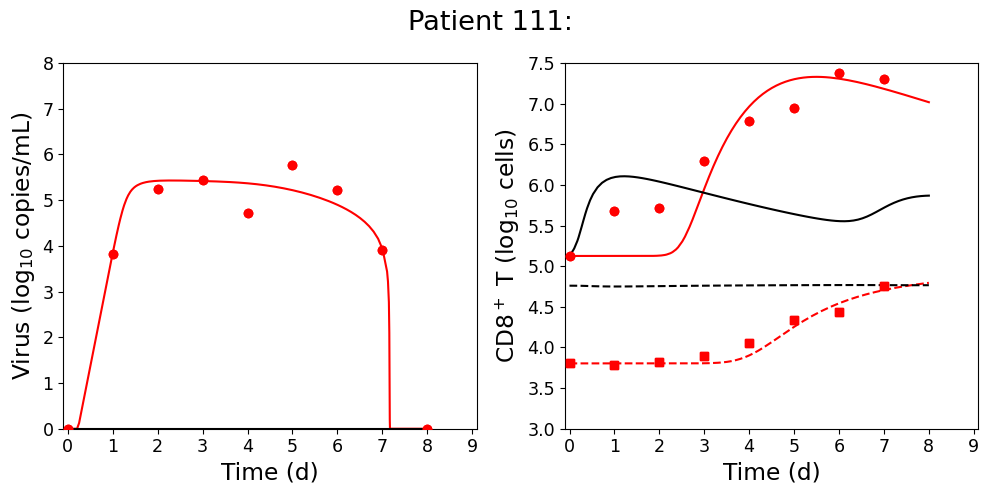

No parameters to optimize
No parameters to optimize


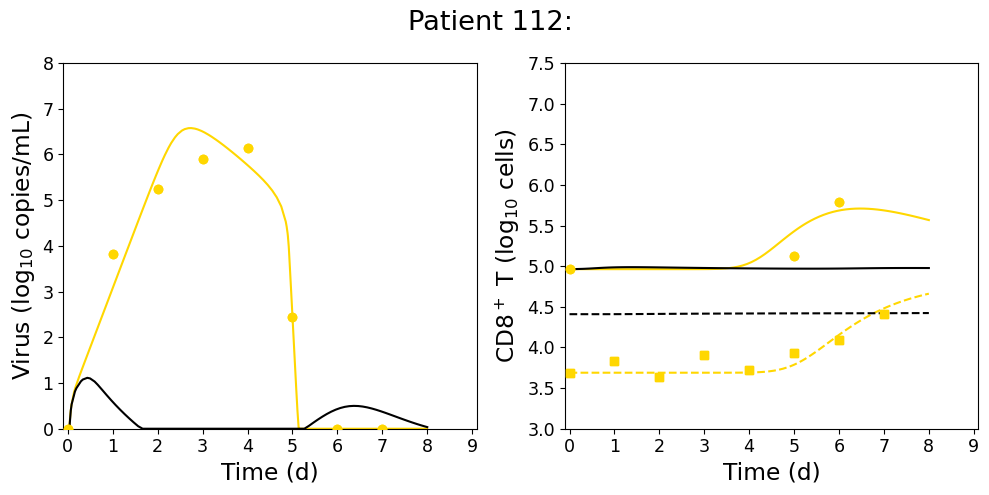

No parameters to optimize
No parameters to optimize


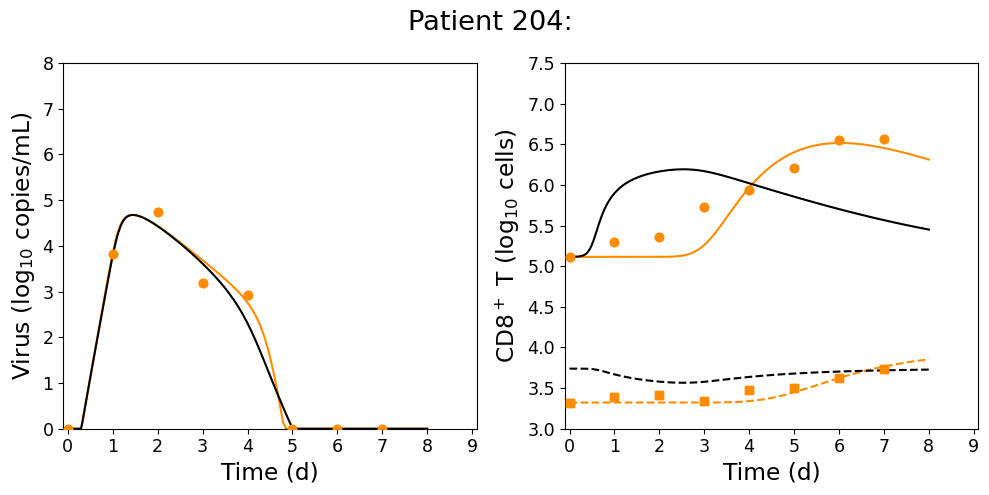

No parameters to optimize
No parameters to optimize


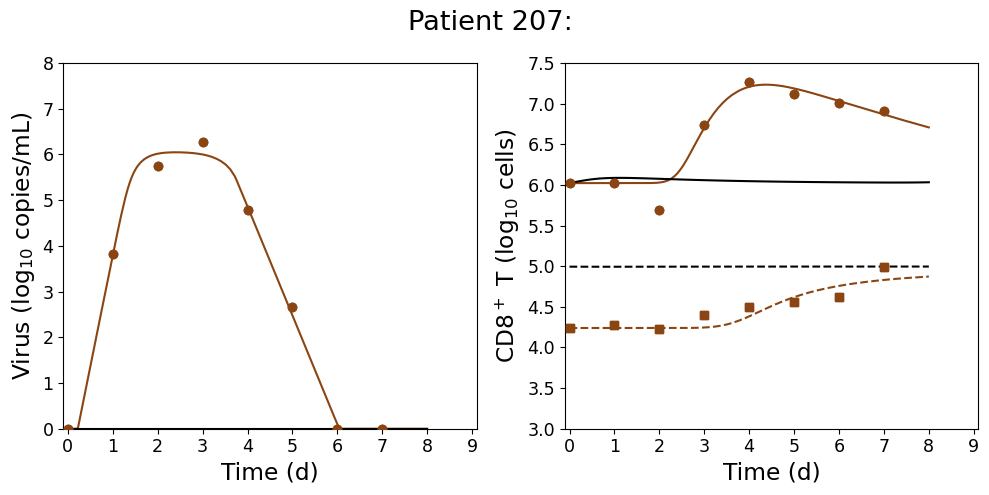

No parameters to optimize
No parameters to optimize


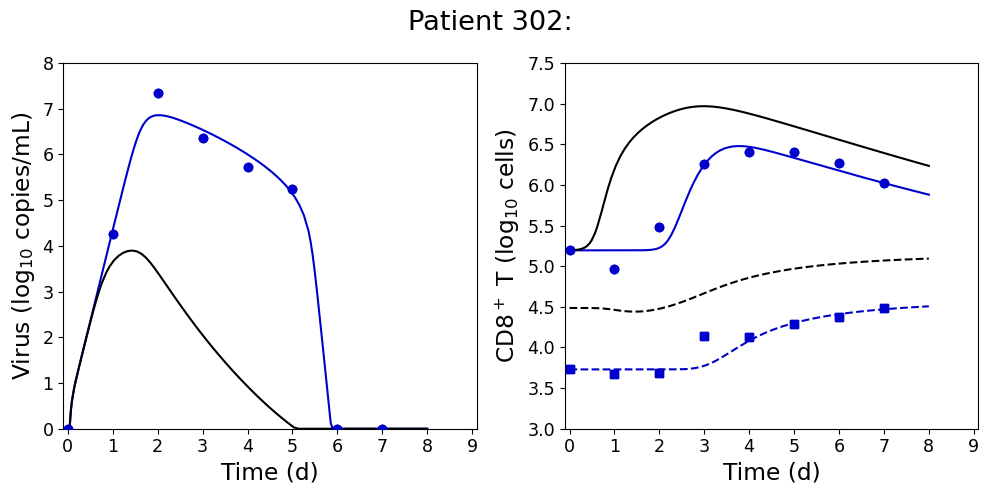

No parameters to optimize
No parameters to optimize


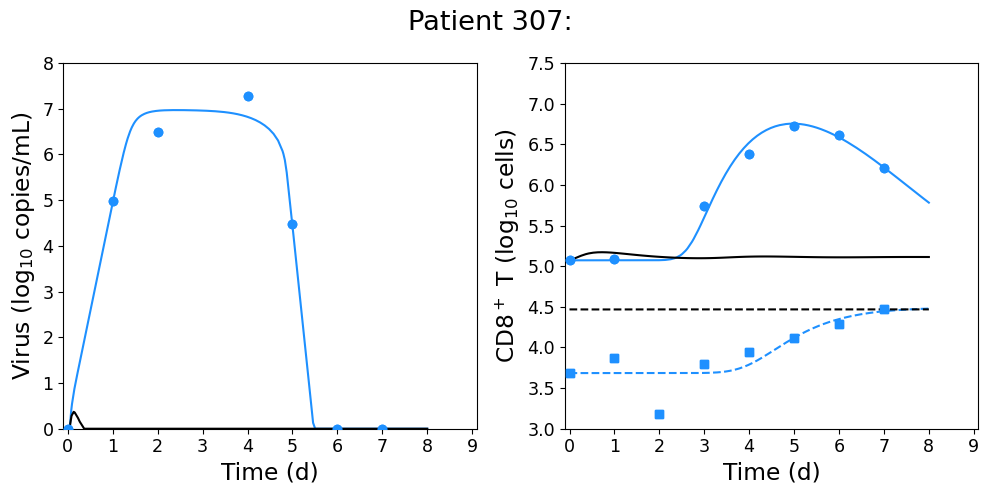

No parameters to optimize
No parameters to optimize


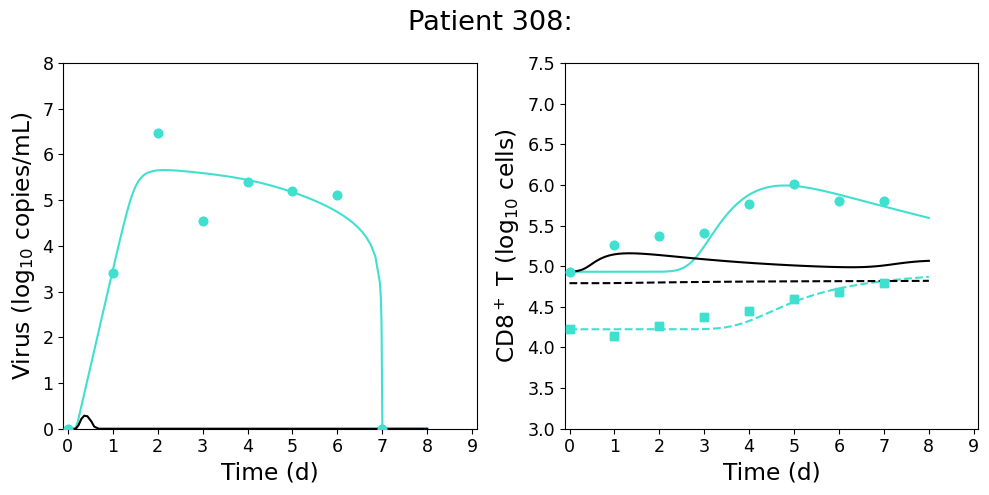

No parameters to optimize
No parameters to optimize


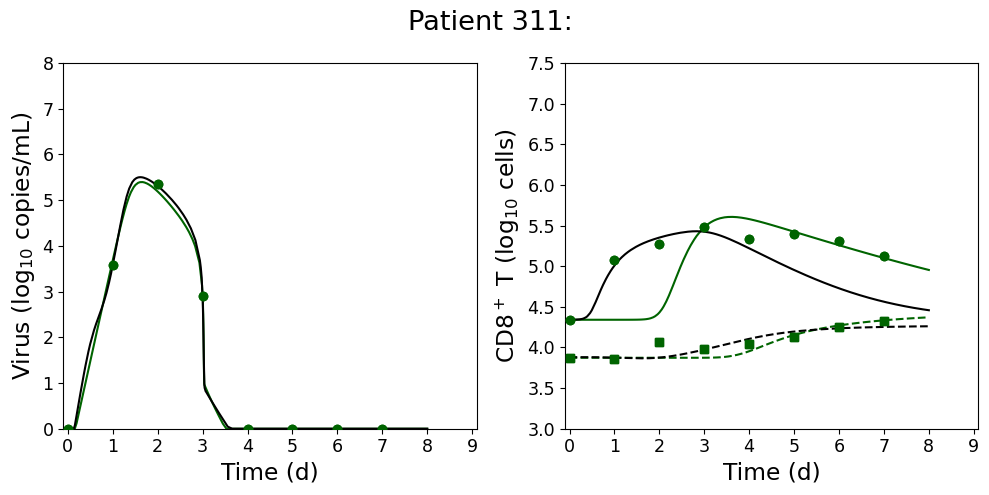

No parameters to optimize
No parameters to optimize


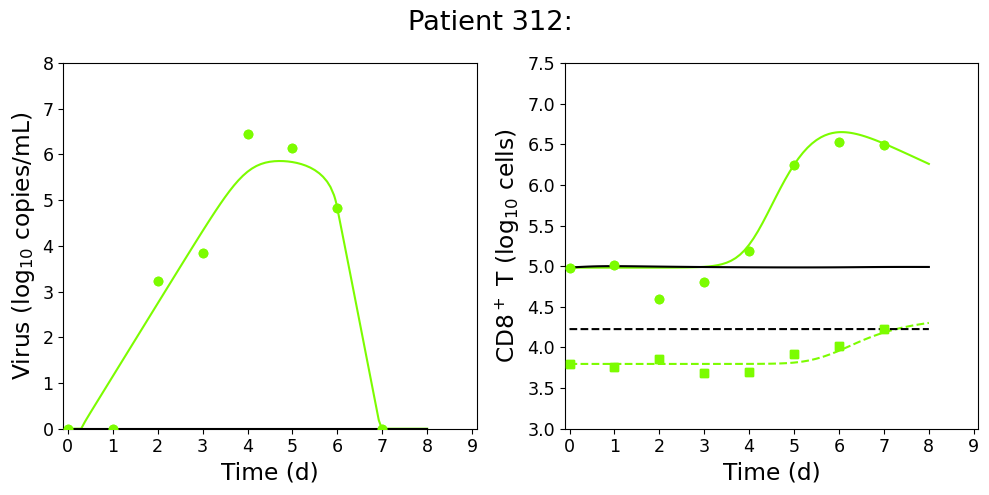

In [21]:
# Rahil Setup - Rechallenge Forecast

subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, 'sol_key': 0, 'ylims': [0, 8]},
    #{'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1, 'ylims': [0, 8]},
    #{'title': 'Infected Cells', 'data_key': None, 'sol_key': 2, 'ylims': [0, 8]},
    {'title': 'Virus', 'data_key': 'V', 'sol_key': 3,'ylims': [0,8]},
    {'title': 'T Cells', 'data_key': ['CD8TE','CD8TM'], 'sol_key': [4, 5], 'ylims': [3,7.5]}, 
    #{'title': 'T Memory', 'data_key': 'CD8TM', 'sol_key': 5, 'ylims': [3,5.25]}, 
]

n_Z = 13
# Import data
df = pd.read_excel("../Data/Rahil_2020/Table8_Healed.xlsx", sheet_name='112Cens')
df_Rahil = df[['VOLUNTEER', 'DAY', 'V', 'IFNG', 'CD8TE', 'CD8TM']]

states = [
    {'label': 'T', 'initial_value': 4E7, 'sse': False},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TE', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TM', 'initial_value': 0.0, 'sse': False},
]

for i in range(1, n_Z + 1):
    states.append({'label': f'Z{i}', 'initial_value': 0.0, 'sse': False})
states.append({'label': 'CD8T_Tot', 'initial_value': 0.0, 'sse': False})

parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=2.1E4, u_lim=1.7E5, method='file', space='log10'),
    M0=Parameter(name='M0', val=1E4, l_lim=2E3, u_lim=3E4, method='file', space='log10'),
    ME=Parameter(name='ME', val=0, l_lim=2E4, u_lim=3E5, method='fixed', space='log10'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=8E7, method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=1E-6, u_lim=1E-3, method='file', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=1, l_lim=0.05, u_lim=10, method='file', space='normal'), 
    c=Parameter(name='c', val=10, l_lim=5.0, u_lim=500, method='file', space='log10'), 
    delta=Parameter(name='delta', val=3, l_lim=0.05, u_lim=5, method='file', space='log10'),
    xi=Parameter(name='xi', val=0.0, l_lim=0.05, u_lim=10, method='file', space='log10'), 
    a=Parameter(name='a', val=0.0, l_lim=1.0, u_lim=10, method='file', space='normal'), 
    d_E=Parameter(name='d_E', val=0.5, l_lim=0.4, u_lim=2, method='file', space='normal'),
    delta_E=Parameter(name='delta_E', val=.75, l_lim=0.5, u_lim=10, method='file', space='log10'),
    K_delta_E=Parameter(name='K_delta_E', val=1.9E4, l_lim=1E2, u_lim=1E5, method='file', space='log10'),
    zeta=Parameter(name='zeta', val=0.07, l_lim=5E-4, u_lim=1E-1, method='file', space='log10'),
    eta=Parameter(name='eta', val=0, l_lim=1, u_lim=100, method='fixed', space='log10'), 
    K_I1=Parameter(name='K_I1', val=10000, l_lim=1E2, u_lim=1E6, method='fixed', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=2.5, l_lim=0.25, u_lim=2, method='file', space='normal'),
)

parameters_rechallenge = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=2E4, u_lim=1.2E6, method='file', space='log10'),
    M0=Parameter(name='M0', val=0, l_lim=2E4, u_lim=3E5, method='file', space='log10'),
    ME=Parameter(name='ME', val=6.6E3, l_lim=2E4, u_lim=3E5, method='file', space='log10'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=8E7, method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=5E-7, u_lim=5E-2, method='file', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=4.184819, l_lim=1, u_lim=10, method='file', space='normal'), 
    c=Parameter(name='c', val=100, l_lim=1.0, u_lim=1000, method='file', space='log10'), 
    delta=Parameter(name='delta', val=3, l_lim=0.1, u_lim=2.5, method='file', space='normal'),
    xi=Parameter(name='xi', val=0.0, l_lim=1E-2, u_lim=10, method='file', space='log10'), 
    a=Parameter(name='a', val=0, l_lim=0.1, u_lim=15, method='fixed', space='normal'), 
    d_E=Parameter(name='d_E', val=0.532, l_lim=0.5, u_lim=3, method='file', space='normal'),
    delta_E=Parameter(name='delta_E', val=7.598, l_lim=1E-1, u_lim=15, method='file', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=36696, l_lim=1E2, u_lim=1E5, method='file', space='log10'),
    zeta=Parameter(name='zeta', val=0.7, l_lim=1E-4, u_lim=1, method='file', space='log10'),
    eta=Parameter(name='eta', val=75.77, l_lim=10, u_lim=2500, method='file', space='log10'),
    K_I1=Parameter(name='K_I1', val=13541, l_lim=1E2, u_lim=1E6, method='file', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=2.5, l_lim=0.5, u_lim=3, method='file', space='normal'),
)

t_span = (0, 8)
patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
patients_rechallenge = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters_rechallenge, states=states, parameter_file='Rechallenge.xlsx')
for target in shedders:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=25, verbose=True, path='Memorytest2')
    results_rechallenge = patients_rechallenge.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=25, verbose=True, path='Memorytest2')
    patient_color = color_mapping.get(target, 'black') 
    plot_per_patient_both_sets(
        results=results,
        results_rechallenge=results_rechallenge,
        subplot_config=subplot_configuration,
        t_span=[0,9],
        figsize=(10,5),
        patient_color=patient_color,
        save=True
    )

No parameters loaded: No file specified. Add parameter_file= to Patients initialization call.
7 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 8.236844623001705
differential_evolution step 2: f(x)= 8.078702345422112
differential_evolution step 3: f(x)= 7.7433860525447615
differential_evolution step 4: f(x)= 7.7433860525447615
differential_evolution step 5: f(x)= 7.7433860525447615
differential_evolution step 6: f(x)= 7.603108483989326
differential_evolution step 7: f(x)= 7.432112665600634
differential_evolution step 8: f(x)= 7.394562071200473
differential_evolution step 9: f(x)= 7.394562071200473
differential_evolution step 10: f(x)= 7.346988842762592
differential_evolution step 11: f(x)= 7.336878240330451
differential_evolution step 12: f(x)= 7.232234080556157
differential_evolution step 13: f(x)= 7.232234080556157
differential_evolution step 14: f(x)= 7.22133621486274
differential_evolution step 15: f(x)= 7.182451543951617
differential_evolution step

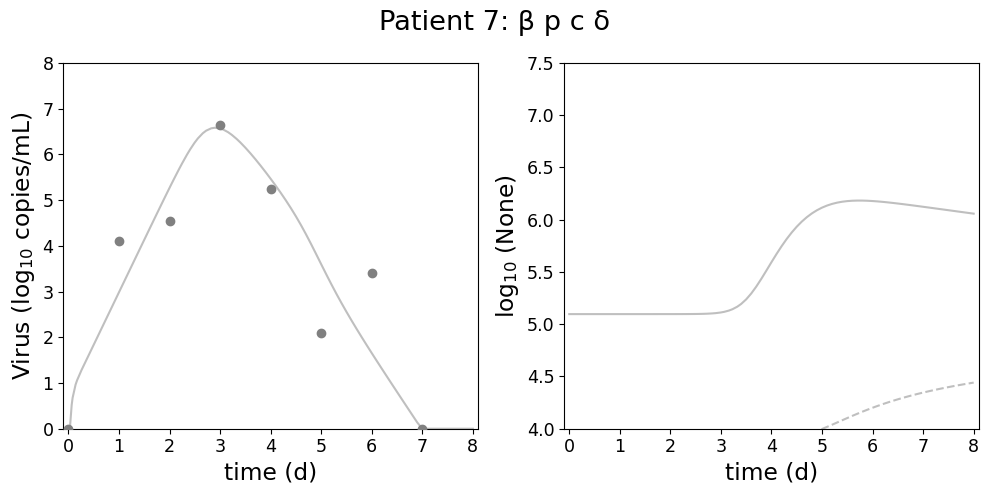

8 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 4.795361939882614
differential_evolution step 2: f(x)= 4.084517587348849
differential_evolution step 3: f(x)= 4.041566817393394
differential_evolution step 4: f(x)= 4.041566817393394
differential_evolution step 5: f(x)= 4.041566817393394
differential_evolution step 6: f(x)= 3.9193554472074963
differential_evolution step 7: f(x)= 3.9193554472074963
differential_evolution step 8: f(x)= 3.7822519825798717
differential_evolution step 9: f(x)= 3.7663399395745727
differential_evolution step 10: f(x)= 3.7574541805735455
differential_evolution step 11: f(x)= 3.7357970369607902
differential_evolution step 12: f(x)= 3.7357970369607902
differential_evolution step 13: f(x)= 3.7357970369607902
differential_evolution step 14: f(x)= 3.7357970369607902
differential_evolution step 15: f(x)= 3.7357970369607902
differential_evolution step 16: f(x)= 3.7259233999336656
differential_evolution step 17: f(x)= 3.715395001855987


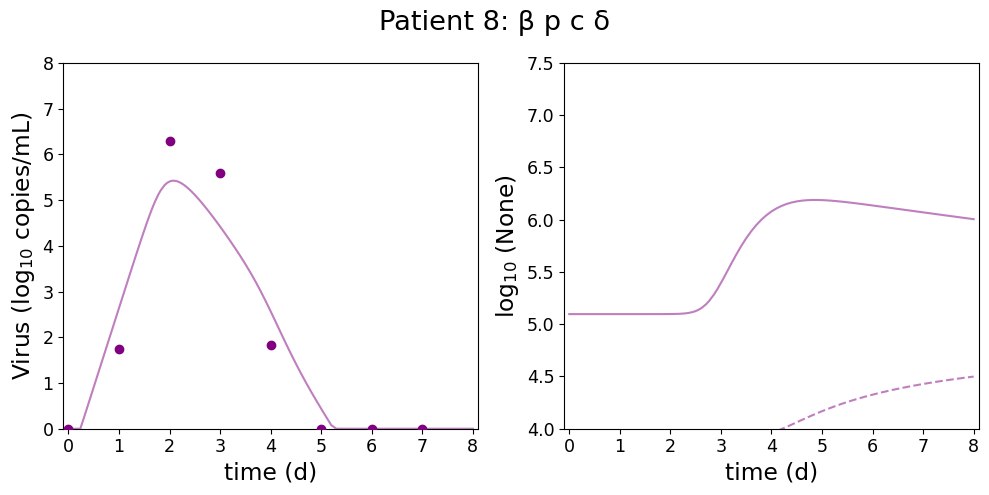

9 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 0.06506436659203967
differential_evolution step 2: f(x)= 0.03344500679742948
differential_evolution step 3: f(x)= 0.03344500679742948
differential_evolution step 4: f(x)= 0.03344500679742948
differential_evolution step 5: f(x)= 0.03329483405195782
differential_evolution step 6: f(x)= 0.03329483405195782
differential_evolution step 7: f(x)= 0.03329483405195782
differential_evolution step 8: f(x)= 0.0321324229377156
differential_evolution step 9: f(x)= 0.03211129888986892
differential_evolution step 10: f(x)= 0.032019642812144845
differential_evolution step 11: f(x)= 0.03149342203521563
differential_evolution step 12: f(x)= 0.03044255782252029
differential_evolution step 13: f(x)= 0.03044255782252029
differential_evolution step 14: f(x)= 0.029965732283916153
differential_evolution step 15: f(x)= 0.029465973677363966
differential_evolution step 16: f(x)= 0.029380783458965092
differential_evolution step 17: 

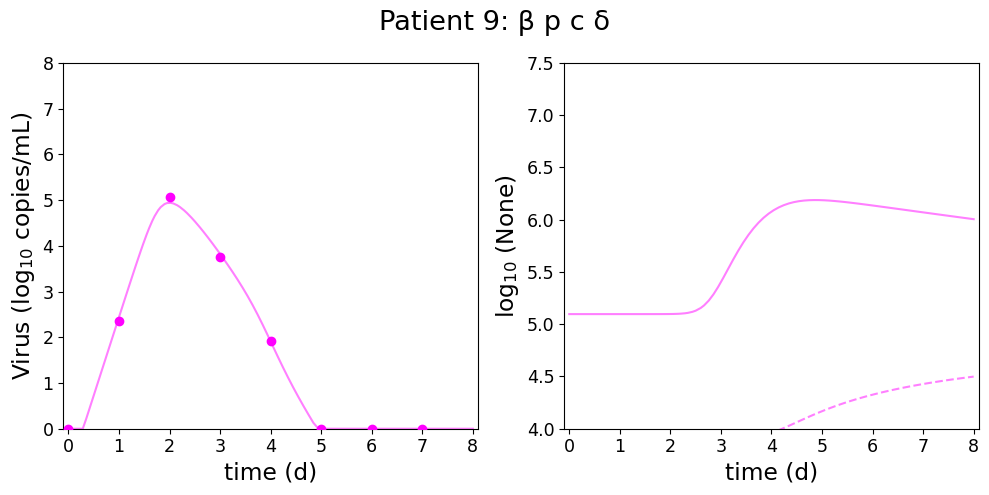

10 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 9.08198424991834
differential_evolution step 2: f(x)= 9.08198424991834
differential_evolution step 3: f(x)= 9.08198424991834
differential_evolution step 4: f(x)= 9.08198424991834
differential_evolution step 5: f(x)= 8.210968982803488
differential_evolution step 6: f(x)= 8.006563200741045
differential_evolution step 7: f(x)= 7.990545104648133
differential_evolution step 8: f(x)= 7.987896268567982
differential_evolution step 9: f(x)= 7.986000003316999
differential_evolution step 10: f(x)= 7.986000003316999
differential_evolution step 11: f(x)= 7.910192533868617
differential_evolution step 12: f(x)= 7.8819739115809035
differential_evolution step 13: f(x)= 7.84551195988528
differential_evolution step 14: f(x)= 7.84551195988528
differential_evolution step 15: f(x)= 7.84551195988528
differential_evolution step 16: f(x)= 7.844967090912013
differential_evolution step 17: f(x)= 7.838018374716261
differential_evo

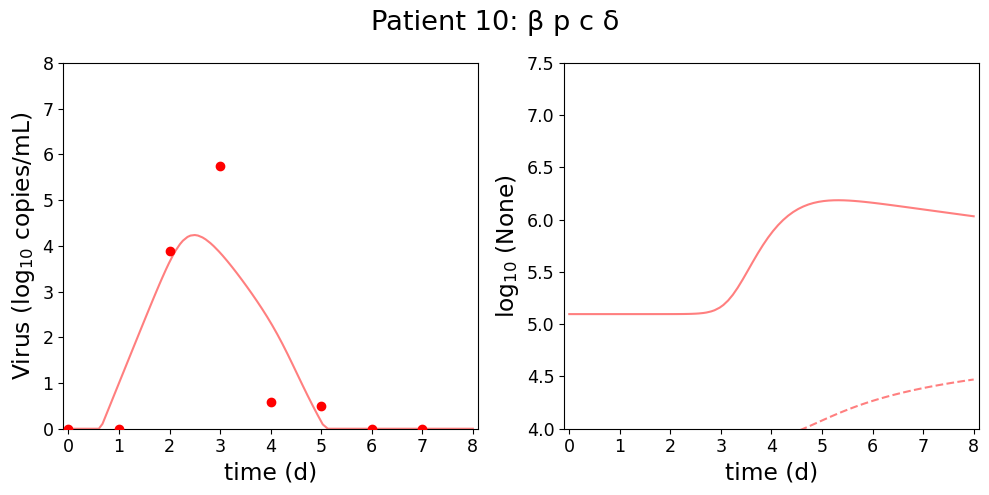

11 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 5.219624365583307
differential_evolution step 2: f(x)= 5.098608794479907
differential_evolution step 3: f(x)= 4.995730784386887
differential_evolution step 4: f(x)= 4.840308173132552
differential_evolution step 5: f(x)= 4.840308173132552
differential_evolution step 6: f(x)= 4.840308173132552
differential_evolution step 7: f(x)= 4.804265113414863
differential_evolution step 8: f(x)= 4.753133574671786
differential_evolution step 9: f(x)= 4.7385518669603535
differential_evolution step 10: f(x)= 4.7385518669603535
differential_evolution step 11: f(x)= 4.7385518669603535
differential_evolution step 12: f(x)= 4.7381558225616995
differential_evolution step 13: f(x)= 4.736935463655252
differential_evolution step 14: f(x)= 4.7361029859031225
Polishing solution with 'L-BFGS-B'
Results saved to sql/Canini_p.db.
Parameter beta: 3.288364957187115e-05
Parameter p: 0.15442864576359838
Parameter c: 8.412890144843551
Pa

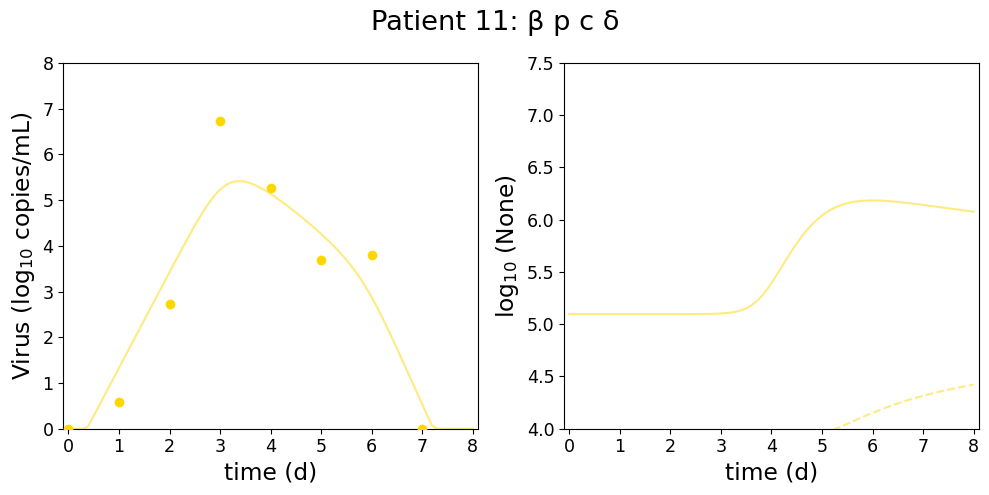

12 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 0.23831461636300227
differential_evolution step 2: f(x)= 0.19663260780975225
differential_evolution step 3: f(x)= 0.17740436261511391
differential_evolution step 4: f(x)= 0.17740436261511391
differential_evolution step 5: f(x)= 0.17740436261511391
differential_evolution step 6: f(x)= 0.17740436261511391
differential_evolution step 7: f(x)= 0.17740436261511391
differential_evolution step 8: f(x)= 0.17517660795053083
differential_evolution step 9: f(x)= 0.16537935951434224
differential_evolution step 10: f(x)= 0.16041549986562187
differential_evolution step 11: f(x)= 0.15962970658681136
differential_evolution step 12: f(x)= 0.159022595910018
differential_evolution step 13: f(x)= 0.159022595910018
differential_evolution step 14: f(x)= 0.159022595910018
differential_evolution step 15: f(x)= 0.1590112731355268
differential_evolution step 16: f(x)= 0.15891247346905654
differential_evolution step 17: f(x)= 0.1

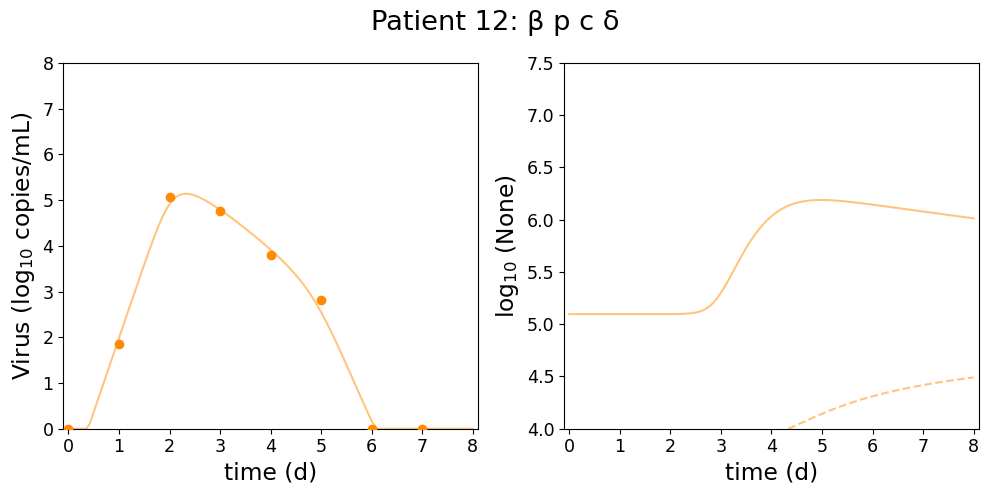

In [2]:
# Canini p
subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, 'sol_key': 0, 'ylims': [0, 8]},
    #{'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1, 'ylims': [0, 8]},
    #{'title': 'Infected Cells', 'data_key': None, 'sol_key': 2, 'ylims': [0, 8]},
    {'title': 'Virus', 'data_key': 'V', 'sol_key': 3,'ylims': [0,8]},
    {'title': 'T Cells', 'data_key': None, 'sol_key': [4, 5], 'ylims': [4,7.5]}, 
]

n_Z = 13
df = pd.read_excel("../Data/Canini.xlsx")
df_Canini = df[['VOLUNTEER', 'DAY', 'V', 'RS', 'SS', 'TSS']]

states = [
    {'label': 'T', 'initial_value': 4E7, 'sse': False},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TE', 'initial_value': 0.0, 'sse': False},
    {'label': 'CD8TM', 'initial_value': 0.0, 'sse': False},
]

for i in range(1, n_Z + 1):
    states.append({'label': f'Z{i}', 'initial_value': 0.0, 'sse': False})
states.append({'label': 'CD8T_Tot', 'initial_value': 0.0, 'sse': False})

parameters = Parameters(
    E0=Parameter(name='E0', val=1.25E5, l_lim=2.1E4, u_lim=1.7E5, method='fixed', space='log10'),
    M0=Parameter(name='M0', val=7497, l_lim=2E3, u_lim=3E4, method='fixed', space='log10'),
    ME=Parameter(name='ME', val=0, l_lim=2E4, u_lim=3E5, method='fixed', space='log10'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=4E7, method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=4.9E-05, l_lim=1E-6, u_lim=1E-3, method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=2.837, l_lim=0.05, u_lim=10, method='fit', space='normal'), 
    c=Parameter(name='c', val=141, l_lim=5.0, u_lim=500, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=1.333, l_lim=0.05, u_lim=5, method='fit', space='log10'),
    xi=Parameter(name='xi', val=0.18, l_lim=0.05, u_lim=10, method='fixed', space='log10'), 
    a=Parameter(name='a', val=7.43, l_lim=1.0, u_lim=10, method='fixed', space='normal'), 
    d_E=Parameter(name='d_E', val=0.17, l_lim=0.05, u_lim=2, method='fixed', space='normal'),
    delta_E=Parameter(name='delta_E', val=.27, l_lim=0.05, u_lim=10, method='fixed', space='log10'),
    K_delta_E=Parameter(name='K_delta_E', val=100000, l_lim=1E2, u_lim=1E5, method='fixed', space='log10'),
    zeta=Parameter(name='zeta', val=0.00469, l_lim=5E-4, u_lim=1E-1, method='fixed', space='log10'),
    eta=Parameter(name='eta', val=0, l_lim=1, u_lim=100, method='fixed', space='log10'), 
    K_I1=Parameter(name='K_I1', val=10000, l_lim=1E2, u_lim=1E6, method='fixed', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=0.266, l_lim=0.25, u_lim=2, method='fixed', space='normal'),
)

t_span = (0, 8)

shedders = list(range(1,13))
#shedders = list(range(13,25))
#shedders = list(range(25,37))
#shedders = list(range(37,45))
targets = ['Population']
ids = targets + shedders
patient_color_names = [
'black',
'gray',
'purple',
'magenta',
'red',
'gold',
'darkorange',
'saddlebrown',
'mediumblue',
'dodgerblue',
'turquoise',
'darkgreen',
'lawngreen']
color_mapping = {id_: color for id_, color in zip(ids, patient_color_names)}

patients = Patients(ids=ids, df=df_Canini, t_span=t_span, parameters=parameters, states=states)
for target in shedders:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=25, verbose=True, path='Canini_p')
    
    patient_color = color_mapping.get(target, 'black') 
    plot(results, subplot_configuration, t_span, figsize=(10,5), patient_color=patient_color)

No parameters loaded: No file specified. Add parameter_file= to Patients initialization call.
1 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 20.996813389451084
differential_evolution step 2: f(x)= 20.996813389451084
differential_evolution step 3: f(x)= 20.996813389451084
differential_evolution step 4: f(x)= 20.34540028531039
differential_evolution step 5: f(x)= 20.34540028531039
differential_evolution step 6: f(x)= 20.34540028531039
differential_evolution step 7: f(x)= 20.34540028531039
differential_evolution step 8: f(x)= 20.34540028531039
differential_evolution step 9: f(x)= 20.34540028531039
differential_evolution step 10: f(x)= 19.936462012075886
differential_evolution step 11: f(x)= 19.936462012075886
differential_evolution step 12: f(x)= 19.936462012075886
differential_evolution step 13: f(x)= 19.936462012075886
differential_evolution step 14: f(x)= 19.936462012075886
differential_evolution step 15: f(x)= 19.819706812509942
differential_evoluti

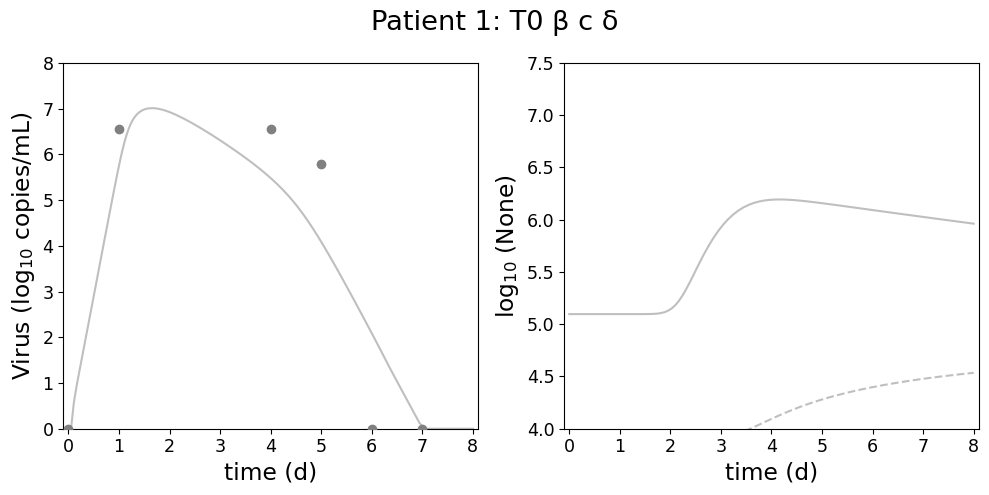

2 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 1.8510955146285497
differential_evolution step 2: f(x)= 1.7420653729022357
differential_evolution step 3: f(x)= 1.6388868906784373
differential_evolution step 4: f(x)= 1.6300142544094087
differential_evolution step 5: f(x)= 1.6300142544094087
differential_evolution step 6: f(x)= 1.5886228657132648
differential_evolution step 7: f(x)= 1.5886228657132648
differential_evolution step 8: f(x)= 1.5886228657132648
differential_evolution step 9: f(x)= 1.5886228657132648
differential_evolution step 10: f(x)= 1.5577667026826125
differential_evolution step 11: f(x)= 1.5577667026826125
differential_evolution step 12: f(x)= 1.5577667026826125
differential_evolution step 13: f(x)= 1.5577667026826125
Polishing solution with 'L-BFGS-B'
Results saved to sql/Canini_T0.db.
Parameter T0: 39816319.176653326
Parameter beta: 1.0769063850489587e-05
Parameter c: 13.369634689252244
Parameter delta: 3.069853577517769


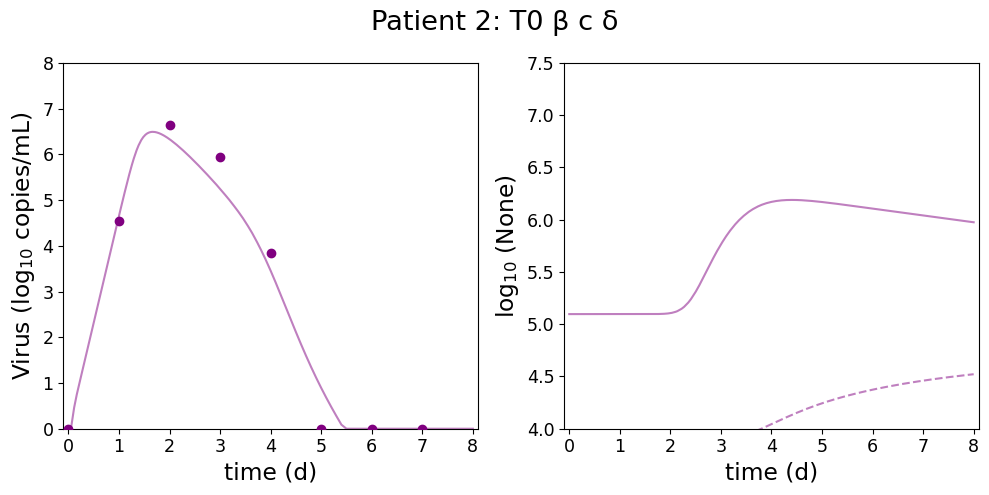

3 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 19.841404310555493
differential_evolution step 2: f(x)= 19.841404310555493
differential_evolution step 3: f(x)= 19.841404310555493
differential_evolution step 4: f(x)= 19.841404310555493
differential_evolution step 5: f(x)= 19.607266860055148
differential_evolution step 6: f(x)= 19.365584382750292
differential_evolution step 7: f(x)= 19.24050156916382
differential_evolution step 8: f(x)= 19.21653194994944
differential_evolution step 9: f(x)= 19.14314589580262
differential_evolution step 10: f(x)= 19.14314589580262
differential_evolution step 11: f(x)= 19.14314589580262
differential_evolution step 12: f(x)= 19.121852284175258
Polishing solution with 'L-BFGS-B'
Results saved to sql/Canini_T0.db.
Parameter T0: 39793241.75479703
Parameter beta: 4.549647225642789e-05
Parameter c: 6.2757145144136945
Parameter delta: 1.8539551556392209


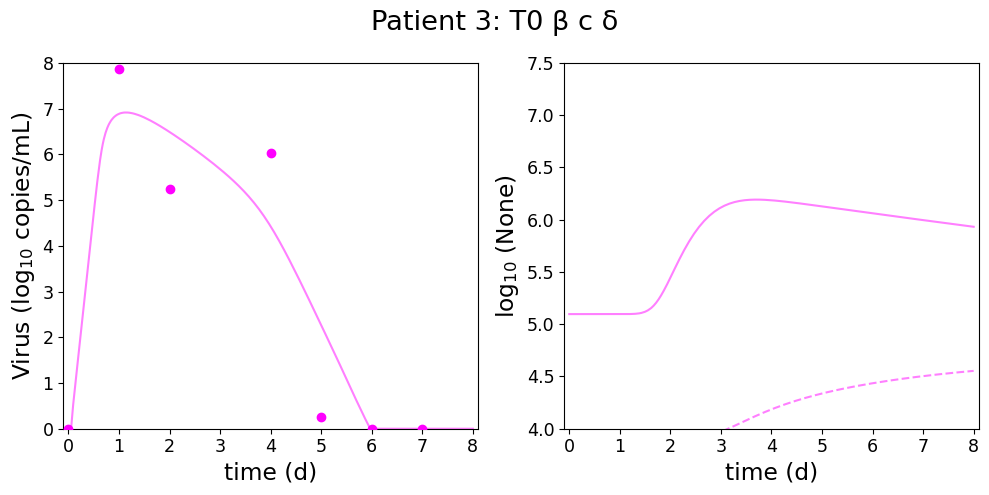

4 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 21.52957725409629
differential_evolution step 2: f(x)= 21.46570198705366
differential_evolution step 3: f(x)= 21.43809274818568
differential_evolution step 4: f(x)= 21.43809274818568
differential_evolution step 5: f(x)= 21.43809274818568
differential_evolution step 6: f(x)= 21.42614756283034
differential_evolution step 7: f(x)= 21.42614756283034
differential_evolution step 8: f(x)= 21.41991347667053
differential_evolution step 9: f(x)= 21.38474621659093
differential_evolution step 10: f(x)= 21.38474621659093
differential_evolution step 11: f(x)= 21.38474621659093
differential_evolution step 12: f(x)= 21.38474621659093
differential_evolution step 13: f(x)= 21.382371518718788
differential_evolution step 14: f(x)= 21.37824041135379
differential_evolution step 15: f(x)= 21.375787649271818
differential_evolution step 16: f(x)= 21.37355462173609
Polishing solution with 'L-BFGS-B'
Results saved to sql/Canini_T0

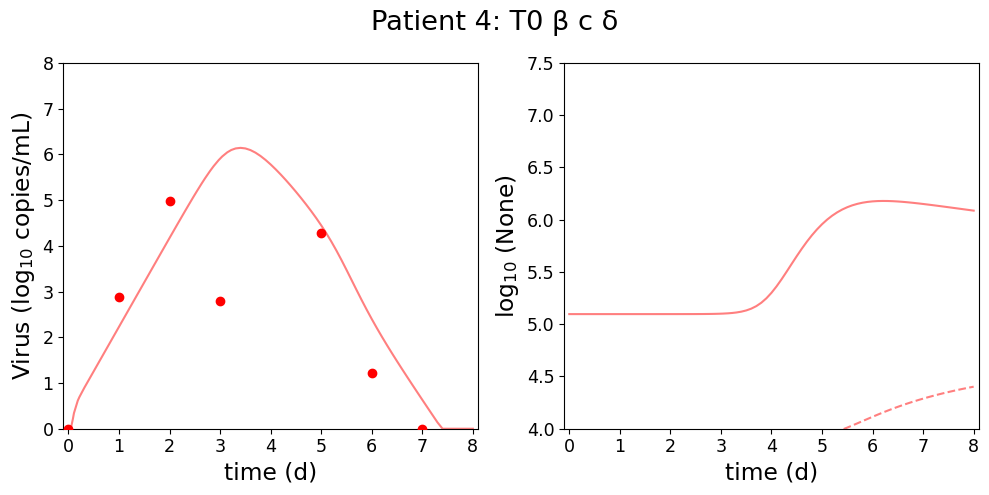

5 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 2.7226243690370002
differential_evolution step 2: f(x)= 2.644671991356098
differential_evolution step 3: f(x)= 2.385583301656599
differential_evolution step 4: f(x)= 2.385583301656599
differential_evolution step 5: f(x)= 2.3461706844578547
differential_evolution step 6: f(x)= 2.3461706844578547
differential_evolution step 7: f(x)= 2.2373925035280378
differential_evolution step 8: f(x)= 2.236440899551192
differential_evolution step 9: f(x)= 2.2236250336767904
differential_evolution step 10: f(x)= 2.195034391843443
differential_evolution step 11: f(x)= 2.195034391843443
differential_evolution step 12: f(x)= 2.195034391843443
differential_evolution step 13: f(x)= 2.195034391843443
differential_evolution step 14: f(x)= 2.193565665267086
differential_evolution step 15: f(x)= 2.1929385835274857
differential_evolution step 16: f(x)= 2.1913584481081214
differential_evolution step 17: f(x)= 2.1904892782102996
dif

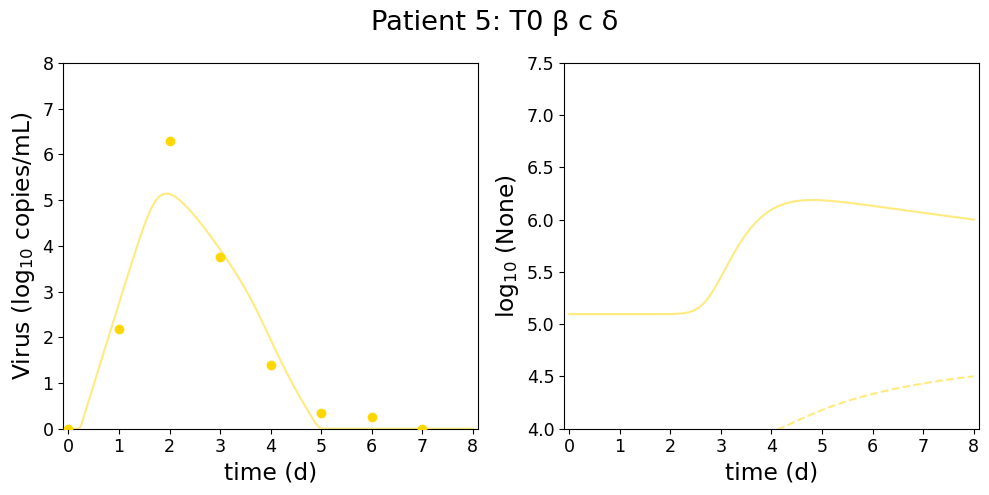

6 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 1.0214716005547853
differential_evolution step 2: f(x)= 0.9862365771049327
differential_evolution step 3: f(x)= 0.9030803206603657
differential_evolution step 4: f(x)= 0.9008004156211913
differential_evolution step 5: f(x)= 0.9005381989538643
differential_evolution step 6: f(x)= 0.8985326055196032
differential_evolution step 7: f(x)= 0.8961052066659188
differential_evolution step 8: f(x)= 0.8953211636439882
differential_evolution step 9: f(x)= 0.8953211636439882
Polishing solution with 'L-BFGS-B'
Results saved to sql/Canini_T0.db.
Parameter T0: 14124500.774979826
Parameter beta: 3.626451797648926e-05
Parameter c: 47.9832536223353
Parameter delta: 2.416255633031786


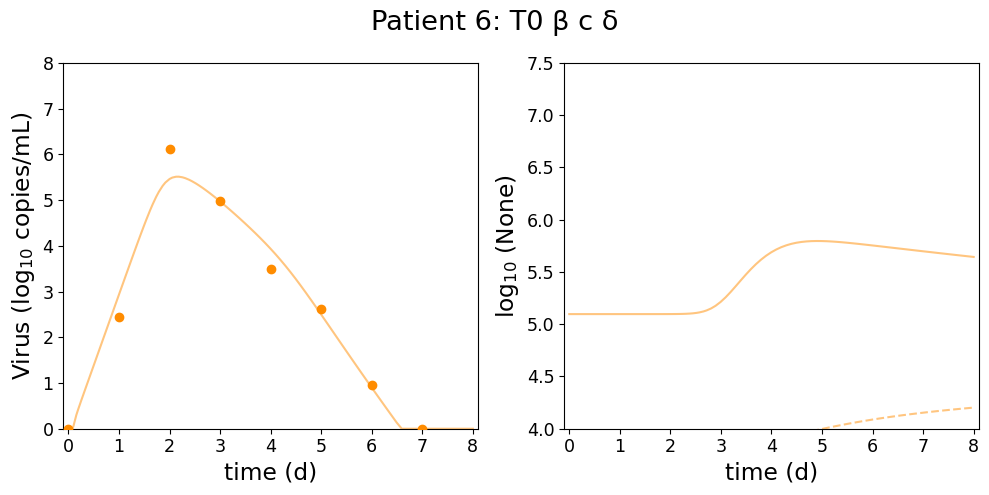

7 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 7.302203809446111
differential_evolution step 2: f(x)= 7.096748157934663
differential_evolution step 3: f(x)= 7.096748157934663
differential_evolution step 4: f(x)= 6.8884777788250755
differential_evolution step 5: f(x)= 6.8884777788250755
differential_evolution step 6: f(x)= 6.8884777788250755
differential_evolution step 7: f(x)= 6.8884777788250755
differential_evolution step 8: f(x)= 6.8884777788250755
differential_evolution step 9: f(x)= 6.8884777788250755
differential_evolution step 10: f(x)= 6.884344803703123
differential_evolution step 11: f(x)= 6.880680655081379
differential_evolution step 12: f(x)= 6.88067087351467
differential_evolution step 13: f(x)= 6.88067087351467
differential_evolution step 14: f(x)= 6.8800279328571685
differential_evolution step 15: f(x)= 6.8800279328571685
differential_evolution step 16: f(x)= 6.8800279328571685
differential_evolution step 17: f(x)= 6.8799258043795355
Pol

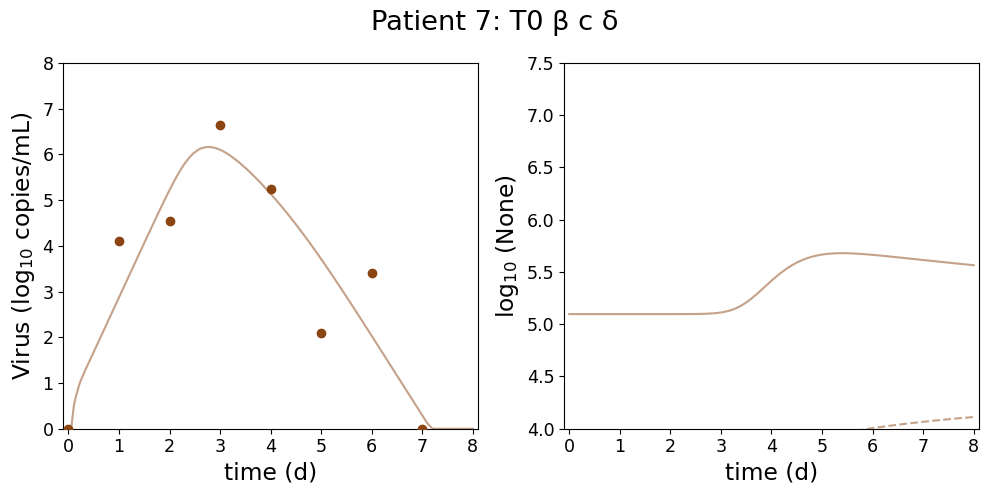

8 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 4.279402444221198
differential_evolution step 2: f(x)= 4.279402444221198
differential_evolution step 3: f(x)= 4.1984774687779876
differential_evolution step 4: f(x)= 4.19635935426653
differential_evolution step 5: f(x)= 4.0500982152309195
differential_evolution step 6: f(x)= 4.0500982152309195
differential_evolution step 7: f(x)= 4.030194483150996
differential_evolution step 8: f(x)= 4.02489131535773
differential_evolution step 9: f(x)= 4.0222380429801
differential_evolution step 10: f(x)= 4.0222380429801
differential_evolution step 11: f(x)= 4.0222380429801
differential_evolution step 12: f(x)= 4.0222380429801
differential_evolution step 13: f(x)= 4.021333798549187
differential_evolution step 14: f(x)= 4.021333798549187
differential_evolution step 15: f(x)= 4.021145556859145
differential_evolution step 16: f(x)= 4.021097984453919
Polishing solution with 'L-BFGS-B'
Results saved to sql/Canini_T0.db.
Para

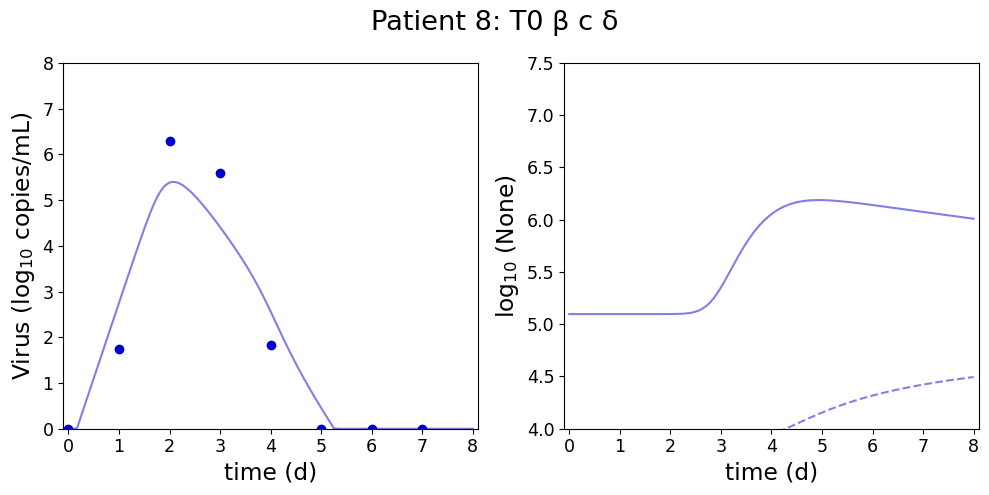

9 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 0.13812997693468806
differential_evolution step 2: f(x)= 0.09906785046056507
differential_evolution step 3: f(x)= 0.04692503063495945
differential_evolution step 4: f(x)= 0.04479541317122792
differential_evolution step 5: f(x)= 0.03589209878278247
differential_evolution step 6: f(x)= 0.03589209878278247
differential_evolution step 7: f(x)= 0.03589209878278247
differential_evolution step 8: f(x)= 0.03329023484895076
differential_evolution step 9: f(x)= 0.03329023484895076
differential_evolution step 10: f(x)= 0.029717101099588288
differential_evolution step 11: f(x)= 0.029717101099588288
differential_evolution step 12: f(x)= 0.029717101099588288
differential_evolution step 13: f(x)= 0.029717101099588288
differential_evolution step 14: f(x)= 0.029717101099588288
differential_evolution step 15: f(x)= 0.029717101099588288
differential_evolution step 16: f(x)= 0.02970151318957402
differential_evolution step 1

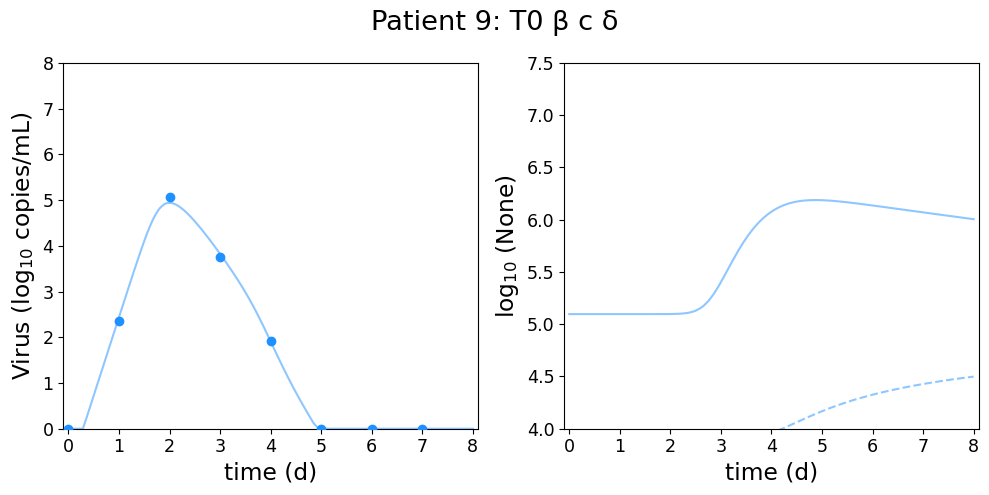

10 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 9.247028453775368
differential_evolution step 2: f(x)= 9.247028453775368
differential_evolution step 3: f(x)= 9.098247410688627
differential_evolution step 4: f(x)= 9.098247410688627
differential_evolution step 5: f(x)= 9.098247410688627
differential_evolution step 6: f(x)= 9.058869356052178
differential_evolution step 7: f(x)= 9.058869356052178
differential_evolution step 8: f(x)= 9.046501618118366
differential_evolution step 9: f(x)= 9.046501618118366
differential_evolution step 10: f(x)= 9.046501618118366
differential_evolution step 11: f(x)= 9.046501618118366
differential_evolution step 12: f(x)= 9.041080807997764
differential_evolution step 13: f(x)= 9.041080807997764
differential_evolution step 14: f(x)= 9.041080807997764
differential_evolution step 15: f(x)= 9.040727652065913
differential_evolution step 16: f(x)= 9.036647017638842
differential_evolution step 17: f(x)= 9.036647017638842
differenti

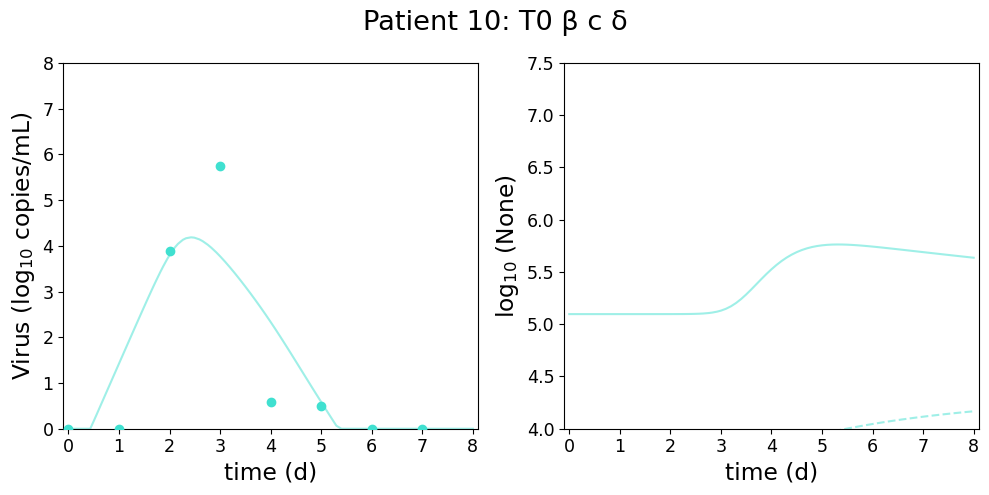

11 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 6.152839138690368
differential_evolution step 2: f(x)= 5.414158727806969
differential_evolution step 3: f(x)= 5.414158727806969
differential_evolution step 4: f(x)= 5.414158727806969
differential_evolution step 5: f(x)= 5.314398406114618
differential_evolution step 6: f(x)= 5.314398406114618
differential_evolution step 7: f(x)= 5.314398406114618
differential_evolution step 8: f(x)= 5.230183055671258
differential_evolution step 9: f(x)= 5.230183055671258
differential_evolution step 10: f(x)= 5.230183055671258
differential_evolution step 11: f(x)= 5.214734407312263
differential_evolution step 12: f(x)= 5.213151490131672
differential_evolution step 13: f(x)= 5.213151490131672
differential_evolution step 14: f(x)= 5.213151490131672
differential_evolution step 15: f(x)= 5.213151490131672
differential_evolution step 16: f(x)= 5.212998324705106
differential_evolution step 17: f(x)= 5.211797570678934
differenti

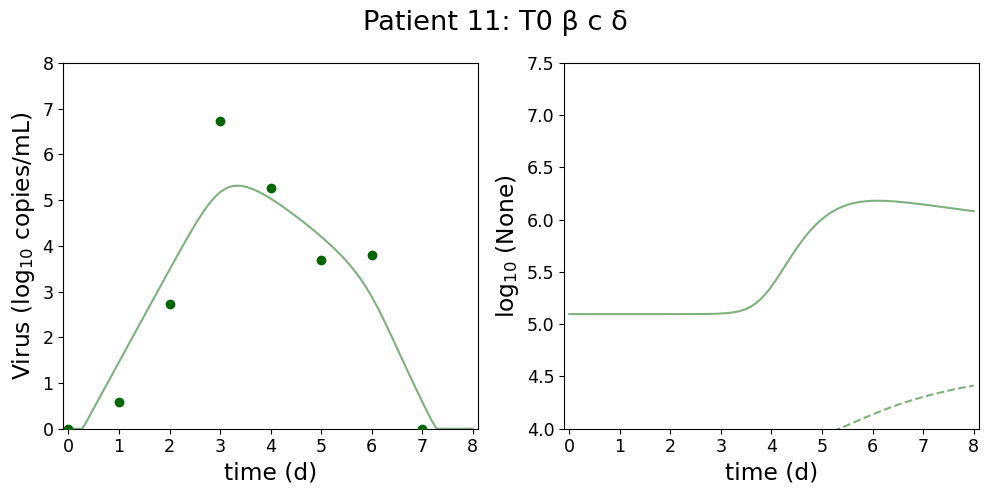

12 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 0.28155676915541383
differential_evolution step 2: f(x)= 0.2809974457181203
differential_evolution step 3: f(x)= 0.2396604741918561
differential_evolution step 4: f(x)= 0.21549097317945234
differential_evolution step 5: f(x)= 0.21549097317945234
differential_evolution step 6: f(x)= 0.2099529015117966
differential_evolution step 7: f(x)= 0.20853657223119695
differential_evolution step 8: f(x)= 0.20853657223119695
differential_evolution step 9: f(x)= 0.20853657223119695
differential_evolution step 10: f(x)= 0.20591474603901613
differential_evolution step 11: f(x)= 0.20445792975209406
differential_evolution step 12: f(x)= 0.20283894022771656
differential_evolution step 13: f(x)= 0.2025812282789371
differential_evolution step 14: f(x)= 0.2025812282789371
differential_evolution step 15: f(x)= 0.2025812282789371
differential_evolution step 16: f(x)= 0.2025812282789371
differential_evolution step 17: f(x)= 0.2

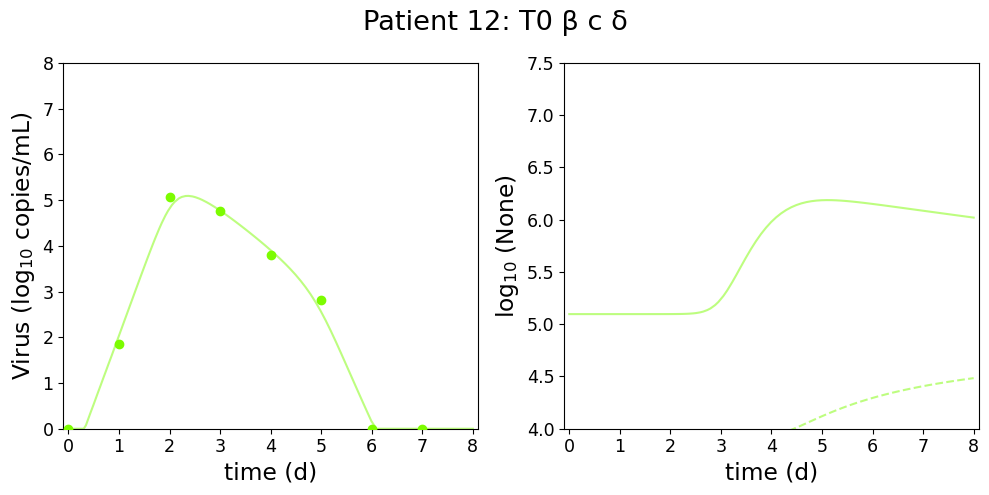

In [3]:
# Canini T0
subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, 'sol_key': 0, 'ylims': [0, 8]},
    #{'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1, 'ylims': [0, 8]},
    #{'title': 'Infected Cells', 'data_key': None, 'sol_key': 2, 'ylims': [0, 8]},
    {'title': 'Virus', 'data_key': 'V', 'sol_key': 3,'ylims': [0,8]},
    {'title': 'T Cells', 'data_key': None, 'sol_key': [4, 5], 'ylims': [4,7.5]}, 
]

n_Z = 13
df = pd.read_excel("../Data/Canini.xlsx")
df_Canini = df[['VOLUNTEER', 'DAY', 'V', 'RS', 'SS', 'TSS']]

states = [
    {'label': 'T', 'initial_value': 4E7, 'sse': False},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TE', 'initial_value': 0.0, 'sse': False},
    {'label': 'CD8TM', 'initial_value': 0.0, 'sse': False},
]

for i in range(1, n_Z + 1):
    states.append({'label': f'Z{i}', 'initial_value': 0.0, 'sse': False})
states.append({'label': 'CD8T_Tot', 'initial_value': 0.0, 'sse': False})

parameters = Parameters(
    E0=Parameter(name='E0', val=1.25E5, l_lim=2.1E4, u_lim=1.7E5, method='fixed', space='log10'),
    M0=Parameter(name='M0', val=7497, l_lim=2E3, u_lim=3E4, method='fixed', space='log10'),
    ME=Parameter(name='ME', val=0, l_lim=2E4, u_lim=3E5, method='fixed', space='log10'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=4E7, method='fit', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=4.9E-05, l_lim=1E-6, u_lim=1E-3, method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=2.837, l_lim=0.05, u_lim=10, method='fixed', space='normal'), 
    c=Parameter(name='c', val=141, l_lim=5.0, u_lim=500, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=1.333, l_lim=0.05, u_lim=5, method='fit', space='log10'),
    xi=Parameter(name='xi', val=0.18, l_lim=0.05, u_lim=10, method='fixed', space='log10'), 
    a=Parameter(name='a', val=7.43, l_lim=1.0, u_lim=10, method='fixed', space='normal'), 
    d_E=Parameter(name='d_E', val=0.17, l_lim=0.05, u_lim=2, method='fixed', space='normal'),
    delta_E=Parameter(name='delta_E', val=.27, l_lim=0.05, u_lim=10, method='fixed', space='log10'),
    K_delta_E=Parameter(name='K_delta_E', val=100000, l_lim=1E2, u_lim=1E5, method='fixed', space='log10'),
    zeta=Parameter(name='zeta', val=0.00469, l_lim=5E-4, u_lim=1E-1, method='fixed', space='log10'),
    eta=Parameter(name='eta', val=0, l_lim=1, u_lim=100, method='fixed', space='log10'), 
    K_I1=Parameter(name='K_I1', val=10000, l_lim=1E2, u_lim=1E6, method='fixed', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=0.266, l_lim=0.25, u_lim=2, method='fixed', space='normal'),
)

t_span = (0, 8)

shedders = list(range(1,13))
#shedders = list(range(13,25))
#shedders = list(range(25,37))
#shedders = list(range(37,45))
targets = ['Population']
ids = targets + shedders
patient_color_names = [
'black',
'gray',
'purple',
'magenta',
'red',
'gold',
'darkorange',
'saddlebrown',
'mediumblue',
'dodgerblue',
'turquoise',
'darkgreen',
'lawngreen']
color_mapping = {id_: color for id_, color in zip(ids, patient_color_names)}

patients = Patients(ids=ids, df=df_Canini, t_span=t_span, parameters=parameters, states=states)
for target in shedders:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=25, verbose=True, path='Canini_T0')
    
    patient_color = color_mapping.get(target, 'black') 
    plot(results, subplot_configuration, t_span, figsize=(10,5), patient_color=patient_color)

In [5]:
def plot_Murine(results, subplot_config, shedders):
    t_span = [0, 12]
    x_ticks = np.arange(t_span[0], t_span[-1] + 1, 1)
    n_subplots = len(subplot_config)
    
    if n_subplots <= 3:
        n_rows, n_cols = 1, n_subplots
    else:
        n_rows, n_cols = int(np.ceil(np.sqrt(n_subplots))), int(np.ceil(n_subplots / np.sqrt(n_subplots)))
    
    base_font_size = 14

    title_font_size = base_font_size * 1.4
    label_font_size = base_font_size * 1.2
    tick_font_size = base_font_size * 0.9

    fit_params_set = set()

    for result, patient in results:
        # Get only the parameters that were fit
        fit_parameters = [param_name for param_name, param in patient.parameters._parameters.items() if param.method == 'fit']
        fit_params_set.update(fit_parameters)

        fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 5), squeeze=False)
        axs_flat = axs.flatten()

        for i, config in enumerate(subplot_config):
            ax = axs_flat[i]
            ax.set_title(config['title'], fontsize=title_font_size)
            if config['data_key']:
                volunteer_data = patient.df[patient.df['VOLUNTEER'].isin(shedders)]
                if config['data_key']=='V' or config['data_key']=='CD8T_Tot':
                    volunteer_data[config['data_key']] = np.log10(np.where(volunteer_data[config['data_key']] < 1, 1, volunteer_data[config['data_key']]))
                group_by_day = volunteer_data.groupby('DAY')[config['data_key']]
                mean_values = group_by_day.mean()
                std_values = group_by_day.std()

                ax.scatter(mean_values.index, mean_values, edgecolor='black',
                            facecolor='white', marker='s', label='Mean', zorder=25, s=75)
                ax.errorbar(mean_values.index, mean_values, yerr=std_values, fmt='none',
                            ecolor='black', capsize=5, label='Std Dev', zorder=20)

            if config['sol_key'] is not None and patient.sol:
                sol_t = patient.sol.t
                if isinstance(config['sol_key'], list):
                    for i, key in enumerate(config['sol_key']):
                        sol_y_raw = patient.sol.y[key]
                        sol_y = np.log10(np.where(sol_y_raw < 1, 1, sol_y_raw))
                        if i == 0:
                            ax.plot(sol_t, sol_y, color=patient.color, alpha=0.5)
                        else:
                            ax.plot(sol_t, sol_y, color=plt.cm.tab10(i), alpha=0.5)
                else:
                    sol_y_raw = patient.sol.y[config['sol_key']]
                    sol_y = np.log10(np.where(sol_y_raw < 1, 1, sol_y_raw))
                    ax.plot(sol_t, sol_y, color=patient.color, alpha=0.5)

            if config['ylims']:
                ax.set_ylim(config['ylims'])

            ax.set_xticks(x_ticks)
            ax.set_xlim([t_span[0] - 0.1, t_span[-1] + 0.1])
            ax.set_xlabel('time (d)', fontsize=label_font_size)
            ax.set_ylabel(f'log10 ({config["data_key"]})', fontsize=label_font_size)
            ax.tick_params(axis='both', which='major', labelsize=tick_font_size)

    plt.tight_layout()
    plt.show()

# Myers Setup
shedders = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
targets = ['Murine']
ids = targets + shedders
subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, 'sol_key': 0,  'ylims': [1, 5E8]},
    #{'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1,  'ylims': [1, 5E8]},
    #{'title': 'Infected Cells', 'data_key': None, 'sol_key': 2,'ylims': [1, 5E8]},
    {'title': 'Virus', 'data_key': 'V', 'sol_key': 3, 'ylims': [0,8]},
    {'title': 'CD8 T Cells', 'data_key': 'CD8T_Tot', 'sol_key': [4, 5, 20], 'ylims': [5.5,6.5]}, #Effector, Memory, Total
]

n_Z = 13
t_span = (0.0, 12.0)
# Import data
df = pd.read_excel("../Data/Murine Data.xlsx", sheet_name='Dynamics')
df_Myers = df[['VOLUNTEER', 'DAY', 'V', 'IFNG', 'CD8T_Tot']]

states = [
    {'label': 'T', 'initial_value': 1E7, 'sse': False},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8T_E', 'initial_value': 0.0, 'sse': False},
    {'label': 'CD8T_Mem', 'initial_value': 0.0, 'sse': False},
]

for i in range(1, n_Z + 1):
    states.append({'label': f'Z{i}', 'initial_value': 0.0, 'sse': False})
states.append({'label': 'CD8T_Tot', 'initial_value': 0.0, 'sse': True})

parameters = Parameters(
    E0=Parameter(name='E0', val=4.2E5, l_lim=2E4, u_lim=1.2E6, method='fixed', space='log10'),
    T0=Parameter(name='T0', val=1E7, l_lim=1E7, u_lim=4.001E7, method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=6.2E-5, l_lim=5E-7, u_lim=5E-2, method='fixed', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=1, l_lim=1, u_lim=10, method='fixed', space='normal'), 
    c=Parameter(name='c', val=9.4, l_lim=10.0, u_lim=1E3, method='fixed', space='log10'), 
    delta=Parameter(name='delta', val=0.24, l_lim=0.4, u_lim=2.5, method='fixed', space='normal'),
    xi=Parameter(name='xi', val=2.1, l_lim=1E-2, u_lim=10.0, method='fixed', space='normal'), 
    a=Parameter(name='a', val=2.3, l_lim=1.0, u_lim=15, method='fixed', space='normal'), 
    d_E=Parameter(name='d_E', val=1.0, l_lim=0.5, u_lim=2.5, method='fixed', space='normal'),
    delta_E=Parameter(name='delta_E', val=1.9, l_lim=1E-1, u_lim=10, method='fixed', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=434, l_lim=1E1, u_lim=1E5, method='fixed', space='log10'),
    zeta=Parameter(name='zeta', val=2.2E-1, l_lim=1E-2, u_lim=1, method='fixed', space='normal'),
    tau_memory=Parameter(name='tau_memory', val=3.5, l_lim=1.0, u_lim=5, method='fixed', space='normal')
)

patients = Patients(ids=ids, df=df_Myers, t_span=t_span, parameters=parameters, states=states)
for target in targets:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=10, verbose=True, path='Murine')

    plot_Murine(results, subplot_configuration, shedders)

No parameters loaded: No file specified. Add parameter_file= to Patients initialization call.
No parameters to optimize
Error solving patient Murine: 'Parameters' object has no attribute 'eta'


AttributeError: 'NoneType' object has no attribute 't'

In [6]:
# Myers Setup

parameters = Parameters(
    E0=Parameter(name='E0', val=4.2E5, l_lim=2E4, u_lim=1.2E6, method='fixed', space='log10'),
    T0=Parameter(name='T0', val=1E7, l_lim=1E7, u_lim=4.001E7, method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=6.2E-5, l_lim=5E-7, u_lim=5E-2, method='fixed', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=1, l_lim=1, u_lim=10, method='fixed', space='normal'), 
    c=Parameter(name='c', val=9.4, l_lim=10.0, u_lim=1E3, method='fixed', space='log10'), 
    delta=Parameter(name='delta', val=0.24, l_lim=0.4, u_lim=2.5, method='fixed', space='normal'),
    xi=Parameter(name='xi', val=2.1, l_lim=1E-2, u_lim=10.0, method='fit', space='normal'), 
    a=Parameter(name='a', val=2.3, l_lim=1.0, u_lim=15, method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=1.0, l_lim=0.5, u_lim=2.5, method='fit', space='normal'),
    delta_E=Parameter(name='delta_E', val=1.9, l_lim=1E-1, u_lim=10, method='fixed', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=434, l_lim=1E1, u_lim=1E5, method='fixed', space='log10'),
    zeta=Parameter(name='zeta', val=2.2E-1, l_lim=1E-2, u_lim=1, method='fit', space='normal'),
    tau_memory=Parameter(name='tau_memory', val=3.5, l_lim=1.0, u_lim=5, method='fixed', space='normal')
)

patients = Patients(ids=ids, df=df_Myers, t_span=t_span, parameters=parameters, states=states)
for target in targets:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=10, verbose=True, path='Murine')

    plot_Murine(results, subplot_configuration, shedders)

No parameters loaded: No file specified. Add parameter_file= to Patients initialization call.
Murine Differential Evolution with 10 generations.
Error solving patient Murine: 'Parameters' object has no attribute 'M0'


AttributeError: 'NoneType' object has no attribute 't'

Population Differential Evolution with 250 generations.


C:\Users\jorda\AppData\Local\Temp\ipykernel_17240\3087843375.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pid_df['VOLUNTEER'] = 'Population'


differential_evolution step 1: f(x)= 688.302353345205
differential_evolution step 2: f(x)= 665.2826431869744
differential_evolution step 3: f(x)= 665.2826431869744
differential_evolution step 4: f(x)= 641.5113967228122
differential_evolution step 5: f(x)= 641.5113967228122
differential_evolution step 6: f(x)= 641.5113967228122
differential_evolution step 7: f(x)= 630.7497459295631
differential_evolution step 8: f(x)= 612.3888953004322
differential_evolution step 9: f(x)= 603.4006209160367
differential_evolution step 10: f(x)= 603.4006209160367
differential_evolution step 11: f(x)= 599.99232794388
differential_evolution step 12: f(x)= 599.8538568661661
differential_evolution step 13: f(x)= 599.8538568661661
differential_evolution step 14: f(x)= 593.4459081336108
differential_evolution step 15: f(x)= 593.4459081336108
differential_evolution step 16: f(x)= 593.4459081336108
differential_evolution step 17: f(x)= 593.4459081336108
differential_evolution step 18: f(x)= 592.100166708294
diffe

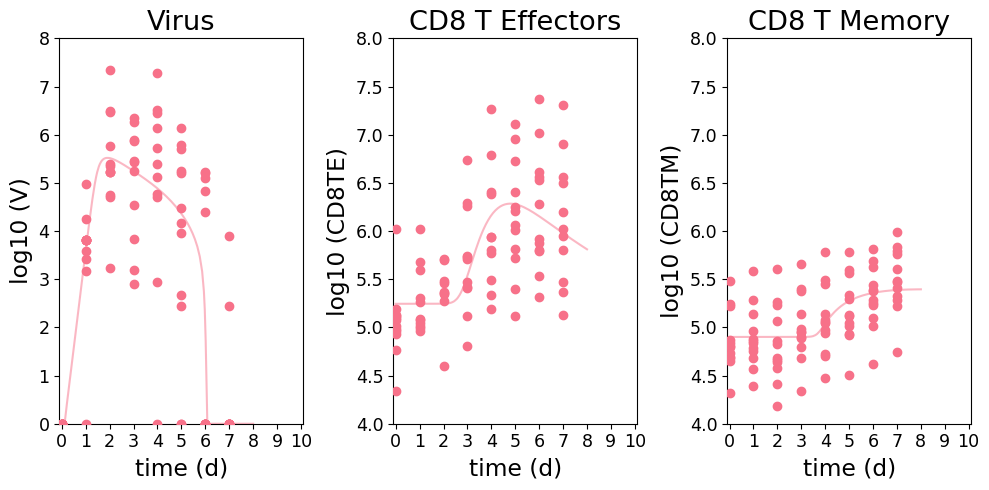

In [29]:
parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=2E4, u_lim=1.2E6, method='fit', space='log10'),
    M0=Parameter(name='M0', val=3.43E5, l_lim=2E4, u_lim=3E5, method='fit', space='log10'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=8E7, method='fit', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=1E-6, u_lim=1E-3, method='file', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=4.184819, l_lim=1, u_lim=10, method='fixed', space='normal'), 
    c=Parameter(name='c', val=13.934, l_lim=1.0, u_lim=250, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=0.96, l_lim=0.1, u_lim=2.5, method='fit', space='normal'),
    xi=Parameter(name='xi', val=0.1198, l_lim=1E-2, u_lim=7.5, method='fit', space='log10'), 
    a=Parameter(name='a', val=2.5, l_lim=0.1, u_lim=15, method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=0.75, l_lim=0.5, u_lim=3, method='fit', space='normal'),
    delta_E=Parameter(name='delta_E', val=8.939, l_lim=1E-1, u_lim=10, method='fit', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=1.3E4, l_lim=1E1, u_lim=1E5, method='fit', space='log10'),
    zeta=Parameter(name='zeta', val=2.2E-1, l_lim=1E-4, u_lim=1, method='fit', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=3.5, l_lim=0.5, u_lim=3, method='fit', space='normal')
)

patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
for target in targets:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=250, verbose=True, path='MemoryRahilComplete10x')

    plot(results, subplot_configuration)